In [1]:
import pandas as pd
# %env PYTORCH_ENABLE_MPS_FALLBACK=1
%load_ext autoreload
%autoreload

from bins import Bins
from eventsreader import Frame
from hist_utils import HistMaker, HistMaker1d, geom_avg1d, symmetrize, CombinedHistMaker, SignalHistMaker
from hist_template import set_opt_text, set_th1, set_pad
import helicity_model_1d
import helicity_model_3d
from plotting import plot_losses, show_results, paveTexts, show_mass_z
from ROOT import TH1, TF1, TCanvas, gStyle, TLegend
import calendar, os
from time import gmtime

Welcome to JupyROOT 6.28/04


In [2]:
#!pip install openpyxl

In [3]:
gStyle.SetOptStat(0)

analyse_3d = False
learn_norm = False
same_sign_symm = True
ag1580ag = True
event_mixing = False
symmetrize_explicit = False
read_saved = False
range_used = range(0,12)
fraction = 100.0
#fraction = 0.8
frame = Frame.HX

DIR_NAME = f"results_{'ag1580ag' if ag1580ag else 'ag1230ag'}_{'3d' if analyse_3d else '1d'}_{'symm' if same_sign_symm else 'nosymm'}_{frame.name}{'_mix' if event_mixing else ''}"
if not os.path.isdir(DIR_NAME):
    os.mkdir(DIR_NAME)

In [4]:
import torch

torch.device("mps")
torch.manual_seed(0)

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm.notebook import tqdm

import warnings

In [5]:
TH1.SetDefaultSumw2()

In [6]:

if ag1580ag:
    ekin = 1580
   # The right one
    filename_data_np = "063_088_ag158ag_3200A_accepted_np.dat"
   # UrQMD
   # filename_data_np = "mar19_diele_no_enhancement_gcalor_np.dat"
   # filename_data_np = "mar19_diele_inmedium_helip1cm_ag1580ag_np.dat"
   # Crosscheck
   # filename_data_np = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_np_newCuts_2.dat"

    filename_data_pp = "063_088_ag158ag_3200A_accepted_pp.dat"
    filename_data_nn = "063_088_ag158ag_3200A_accepted_nn.dat"
    filename_data_np_mix = "063_088_ag158ag_3200A_accepted_np_mix_hc.dat"
    filename_data_pp_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_pp_mix_hc.dat"
    filename_data_nn_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_nn_mix_hc.dat"
    filename_MC_rho_4pi_heli0 = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_2_np_kine.dat"
    filename_MC_rho_4pi_heli1 = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_2_np_kine.dat"
   # filename_MC_rho_heli0_np = "mar19_diele_inmedium_heli0cm_ag1580ag_np.dat"
   # filename_MC_rho_heli0_np = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_np.dat"
   # filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_pp.dat"
   # filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_nn.dat"
   # filename_MC_rho_heli0_np = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_np_newCuts.dat"
    filename_MC_rho_heli0_np = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_np_newCuts_2.dat"
   # Maybe right ones 
    filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_pp_newCuts.dat"
    filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_nn_newCuts.dat"
   # Check with Mixing 
   # filename_MC_rho_heli0_pp = "mar19_diele_no_enhancement_gcalor_pp_mix.dat"
   # filename_MC_rho_heli0_nn = "mar19_diele_no_enhancement_gcalor_nn_mix.dat"
    filename_MC_rho_heli1 = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_np.dat"
    filename_MC_pi0 = "mar19_diele_pi0_heli0cm_ag1580ag_jver22_np.dat"
    filename_MC_mix = "mar19_diele_pi0_heli0cm_ag1580ag_np_mix.dat"
    if same_sign_symm:
       # The right one
        filename_data_pp = "063_088_ag158ag_3200A_accepted_pp_symm.dat"
       # UrQMD
       # filename_data_pp = "mar19_diele_no_enhancement_gcalor_pp.dat"
       # The right one
        filename_data_nn = "063_088_ag158ag_3200A_accepted_nn_symm.dat"
       # UrQMD
       # filename_data_nn = "mar19_diele_no_enhancement_gcalor_nn.dat"
       # filename_data_pp_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_pp_mix_hc_symm.dat"
       # filename_data_nn_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_nn_mix_hc_symm.dat"
       # filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_pp_swapRandomly.dat"
       # filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_nn_swapRandomly.dat"
else:
    ekin = 1230
   # filename_data_np = "apr12_diele_088_090_ag123ag_2500A_accepted_np_2.dat"
    filename_data_np = "mar19_diele_inmedium_helip1cm_ag1230ag_"
    filename_data_pp = "088_090_ag123ag_2500A_accepted_pp.dat"
    filename_data_nn = "088_090_ag123ag_2500A_accepted_nn.dat"
    filename_data_np_mix = "apr12_diele_089_ag123ag_2500A_accepted_93_np_mix_hc.dat"
    filename_data_pp_mix = "088_090_ag123ag_2500A_accepted_pp_mix_hc.dat"
    filename_data_nn_mix = "088_090_ag123ag_2500A_accepted_nn_mix_hc.dat"
    filename_MC_rho_heli0_np = "mar19_diele_inmedium_heli0cm_ag1230ag_jver22_np.dat"
    filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1230ag_jver22_pp.dat"
    filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1230ag_jver22_nn.dat"
    filename_MC_rho_heli1 = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_np.dat"
    filename_MC_pi0 = "mar19_diele_pi0_heli0cm_ag1580ag_np.dat"
    filename_MC_mix = "mar19_diele_pi0_heli0cm_np_mix.dat"

HistMakerClass = HistMaker if analyse_3d else HistMaker1d

bins = Bins.readFrom("ranges.yml")
#histMakerData_np = HistMakerClass("apr12_diele_088_090_ag123ag_2500A_accepted_np_mix_hc_sample_2.dat", "_data", bins, frame)
if event_mixing:
    histMakerData_np = HistMakerClass(filename_data_np_mix, "_data_np", bins, frame, ekin)
else:
    histMakerData_np = HistMakerClass(filename_data_np, "_data_np", bins, frame, ekin)
histsData_np = histMakerData_np.make_hists  ()
histMakerData_pp = HistMakerClass(filename_data_pp, "_data_pp", bins, frame, ekin)
histsData_pp = histMakerData_pp.make_hists()
histMakerData_nn = HistMakerClass(filename_data_nn, "_data_nn", bins, frame, ekin)
histsData_nn = histMakerData_nn.make_hists()

histMakerData_sig = SignalHistMaker(
    HistMakerClass(filename_data_np, "_data_sig", bins, frame, ekin),
    HistMakerClass(filename_data_pp, "_data_ppb", bins, frame, ekin), 
    HistMakerClass(filename_data_nn, "_data_nnb", bins, frame, ekin),
    HistMakerClass(filename_data_np, "_data_npk", bins, frame, ekin),
    HistMakerClass(filename_data_pp, "_data_ppk", bins, frame, ekin), 
    HistMakerClass(filename_data_nn, "_data_nnk", bins, frame, ekin))

histsData_sig = histMakerData_sig.make_hists  ()

histMakerData_np_mix = HistMakerClass(filename_data_np_mix, "_data_np_mix", bins, frame, ekin)
histsData_np_mix = histMakerData_np_mix.make_hists()
histMakerData_pp_mix = HistMakerClass(filename_data_np_mix, "_data_pp_mix", bins, frame, ekin)
histsData_pp_mix = histMakerData_pp_mix.make_hists()
histMakerData_nn_mix = HistMakerClass(filename_data_nn_mix, "_data_nn_mix", bins, frame, ekin)
histsData_nn_mix = histMakerData_nn_mix.make_hists()

histMakerMC_rho_heli0_np = HistMakerClass(filename_MC_rho_heli0_np, "_MC_rho_heli0", bins, frame, ekin)
histMakerMC_rho_heli0_pp = HistMakerClass(filename_MC_rho_heli0_pp, "_MC_rho_heli0_pp", bins, frame, ekin)
histMakerMC_rho_heli0_nn = HistMakerClass(filename_MC_rho_heli0_nn, "_MC_rho_heli0_nn", bins, frame, ekin)
histMakerMC_rho_heli1 = HistMakerClass(filename_MC_rho_heli1, "_MC_rho_heli1", bins, frame, ekin)
histMakerMC_pi0 = HistMakerClass(filename_MC_pi0, "_MC_pi0", bins, frame, ekin)
histMakerMC_mix = HistMakerClass(filename_MC_mix, "_MC_mix", bins, frame, ekin)
#histMakerMC_mix = HistMakerClass("test_inmedium_heli0cm_np_mix.dat", "_MC_rho_mix", bins, frame)
#histMakerMC_mix = HistMakerClass("mar19_diele_pi0_heli0cm_np_mix.dat", "_MC_rho_mix", bins, frame)
def get_hist_maker_mc(sign, hist_index):
    if event_mixing:
        return histMakerMC_mix
    else:
        if hist_index < 3:
            return CombinedHistMaker(histMakerMC_pi0, histMakerMC_rho_heli0_np, fraction)
        else:
            if sign == "np" or sign == "sig":
                return histMakerMC_rho_heli0_np
            elif sign == "pp":
                return histMakerMC_rho_heli0_pp
            else:
                return histMakerMC_rho_heli0_nn
        # return histMakerMC_rho_heli0_np

Pickle file exists
[01/25/2024, 18:52:24]: iter  0
[01/25/2024, 18:52:24] Before processing events
Num events 411996
Num non-null events 411996
[01/25/2024, 18:52:25] After processing events
#1 result length 5
Pickle file exists
[01/25/2024, 18:52:25]: iter  1
[01/25/2024, 18:52:25] Before processing events
Num events 82572
Num non-null events 82572
[01/25/2024, 18:52:26] After processing events
#1 result length 5
Pickle file exists
[01/25/2024, 18:52:26]: iter  2
[01/25/2024, 18:52:26] Before processing events
Num events 134850
Num non-null events 134850
[01/25/2024, 18:52:27] After processing events
#1 result length 5
Pickle file exists
[01/25/2024, 18:52:29]: iter  3
[01/25/2024, 18:52:29] Before processing events
Num events 411996
Num non-null events 411996
[01/25/2024, 18:52:30] After processing events
#1 result length 5
Pickle file exists
[01/25/2024, 18:52:30]: iter  4
[01/25/2024, 18:52:30] Before processing events
Num events 82572
Num non-null events 82572
[01/25/2024, 18:52:3

Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_m06p00_data_ppb_iter5 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_m06p00_data_ppk_iter8 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p00p03_data_ppb_iter5 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p00p03_data_ppk_iter8 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p03p08_data_ppb_iter5 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p03p08_data_ppk_iter8 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_m06p00_data_ppb_iter5 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_m06p00_data_ppk_iter8 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_p00p03_data_ppb_iter5 (Potential memory le

In [7]:
torch.backends.mps.is_available()
#mps_device = torch.device("mps")
mps_device = torch.device("cpu")
bounds = torch.tensor([[-2, ],
                       [ 2, ]], dtype=torch.float)
bounds = bounds.to(mps_device)


xs = torch.linspace(bounds[0][0], bounds[1][0], 101)

In [8]:
parameters_all_np = []
losses_all_np = [[]]* len(range_used)

fit_simple = helicity_model_3d.fit_simple if analyse_3d else helicity_model_1d.fit_simple

for HIST_INDEX in range_used:
    simple_model = helicity_model_3d.Helicity3d(learn_norm) if analyse_3d else helicity_model_1d.Helicity1d(learn_norm)
    hist_data_simple = histsData_np[0][HIST_INDEX]
    hist_mc_simple = get_hist_maker_mc("np", HIST_INDEX).make_hists(0.0)[0][HIST_INDEX]
    if HIST_INDEX == 2:
        losses = fit_simple(simple_model, hist_data_simple, hist_mc_simple, 1000, 0.01, learn_norm)
    else:
        losses = fit_simple(simple_model, hist_data_simple, hist_mc_simple, 1000, 0.01, learn_norm)
    parameters_all_np.append([param for param in simple_model.parameters()])
    losses_all_np[HIST_INDEX] = losses
    
parameters_all_pp = []
losses_all_pp = [[]]* len(range_used)

for HIST_INDEX in range_used:
    simple_model = helicity_model_3d.Helicity3d(learn_norm) if analyse_3d else helicity_model_1d.Helicity1d(learn_norm)
    hist_data_simple = histsData_pp[0][HIST_INDEX]
    hist_mc_simple = get_hist_maker_mc("pp", HIST_INDEX).make_hists(0.0)[0][HIST_INDEX]
    losses = fit_simple(simple_model, hist_data_simple, hist_mc_simple, 10000, 0.01, learn_norm)
    parameters_all_pp.append([param for param in simple_model.parameters()])
    losses_all_pp[HIST_INDEX] = losses
    
parameters_all_nn = []
losses_all_nn = [[]]* len(range_used)

for HIST_INDEX in range_used:
    simple_model = helicity_model_3d.Helicity3d(learn_norm) if analyse_3d else helicity_model_1d.Helicity1d(learn_norm)
    hist_data_simple = histsData_nn[0][HIST_INDEX]
    hist_mc_simple = get_hist_maker_mc("nn", HIST_INDEX).make_hists(0.0)[0][HIST_INDEX]
    losses = fit_simple(simple_model, hist_data_simple, hist_mc_simple, 10000, 0.01, learn_norm)
    parameters_all_nn.append([param for param in simple_model.parameters()])
    losses_all_nn[HIST_INDEX] = losses
    
parameters_all_sig = []
losses_all_sig = [[]]* len(range_used)

for HIST_INDEX in range_used:
    simple_model = helicity_model_3d.Helicity3d(learn_norm) if analyse_3d else helicity_model_1d.Helicity1d(learn_norm)
    hist_data_simple = histsData_sig[0][HIST_INDEX]
    hist_mc_simple = get_hist_maker_mc("sig", HIST_INDEX).make_hists(0.0)[0][HIST_INDEX]
    losses = fit_simple(simple_model, hist_data_simple, hist_mc_simple, 10000, 0.01, learn_norm)
    parameters_all_sig.append([param for param in simple_model.parameters()])
    losses_all_sig[HIST_INDEX] = losses

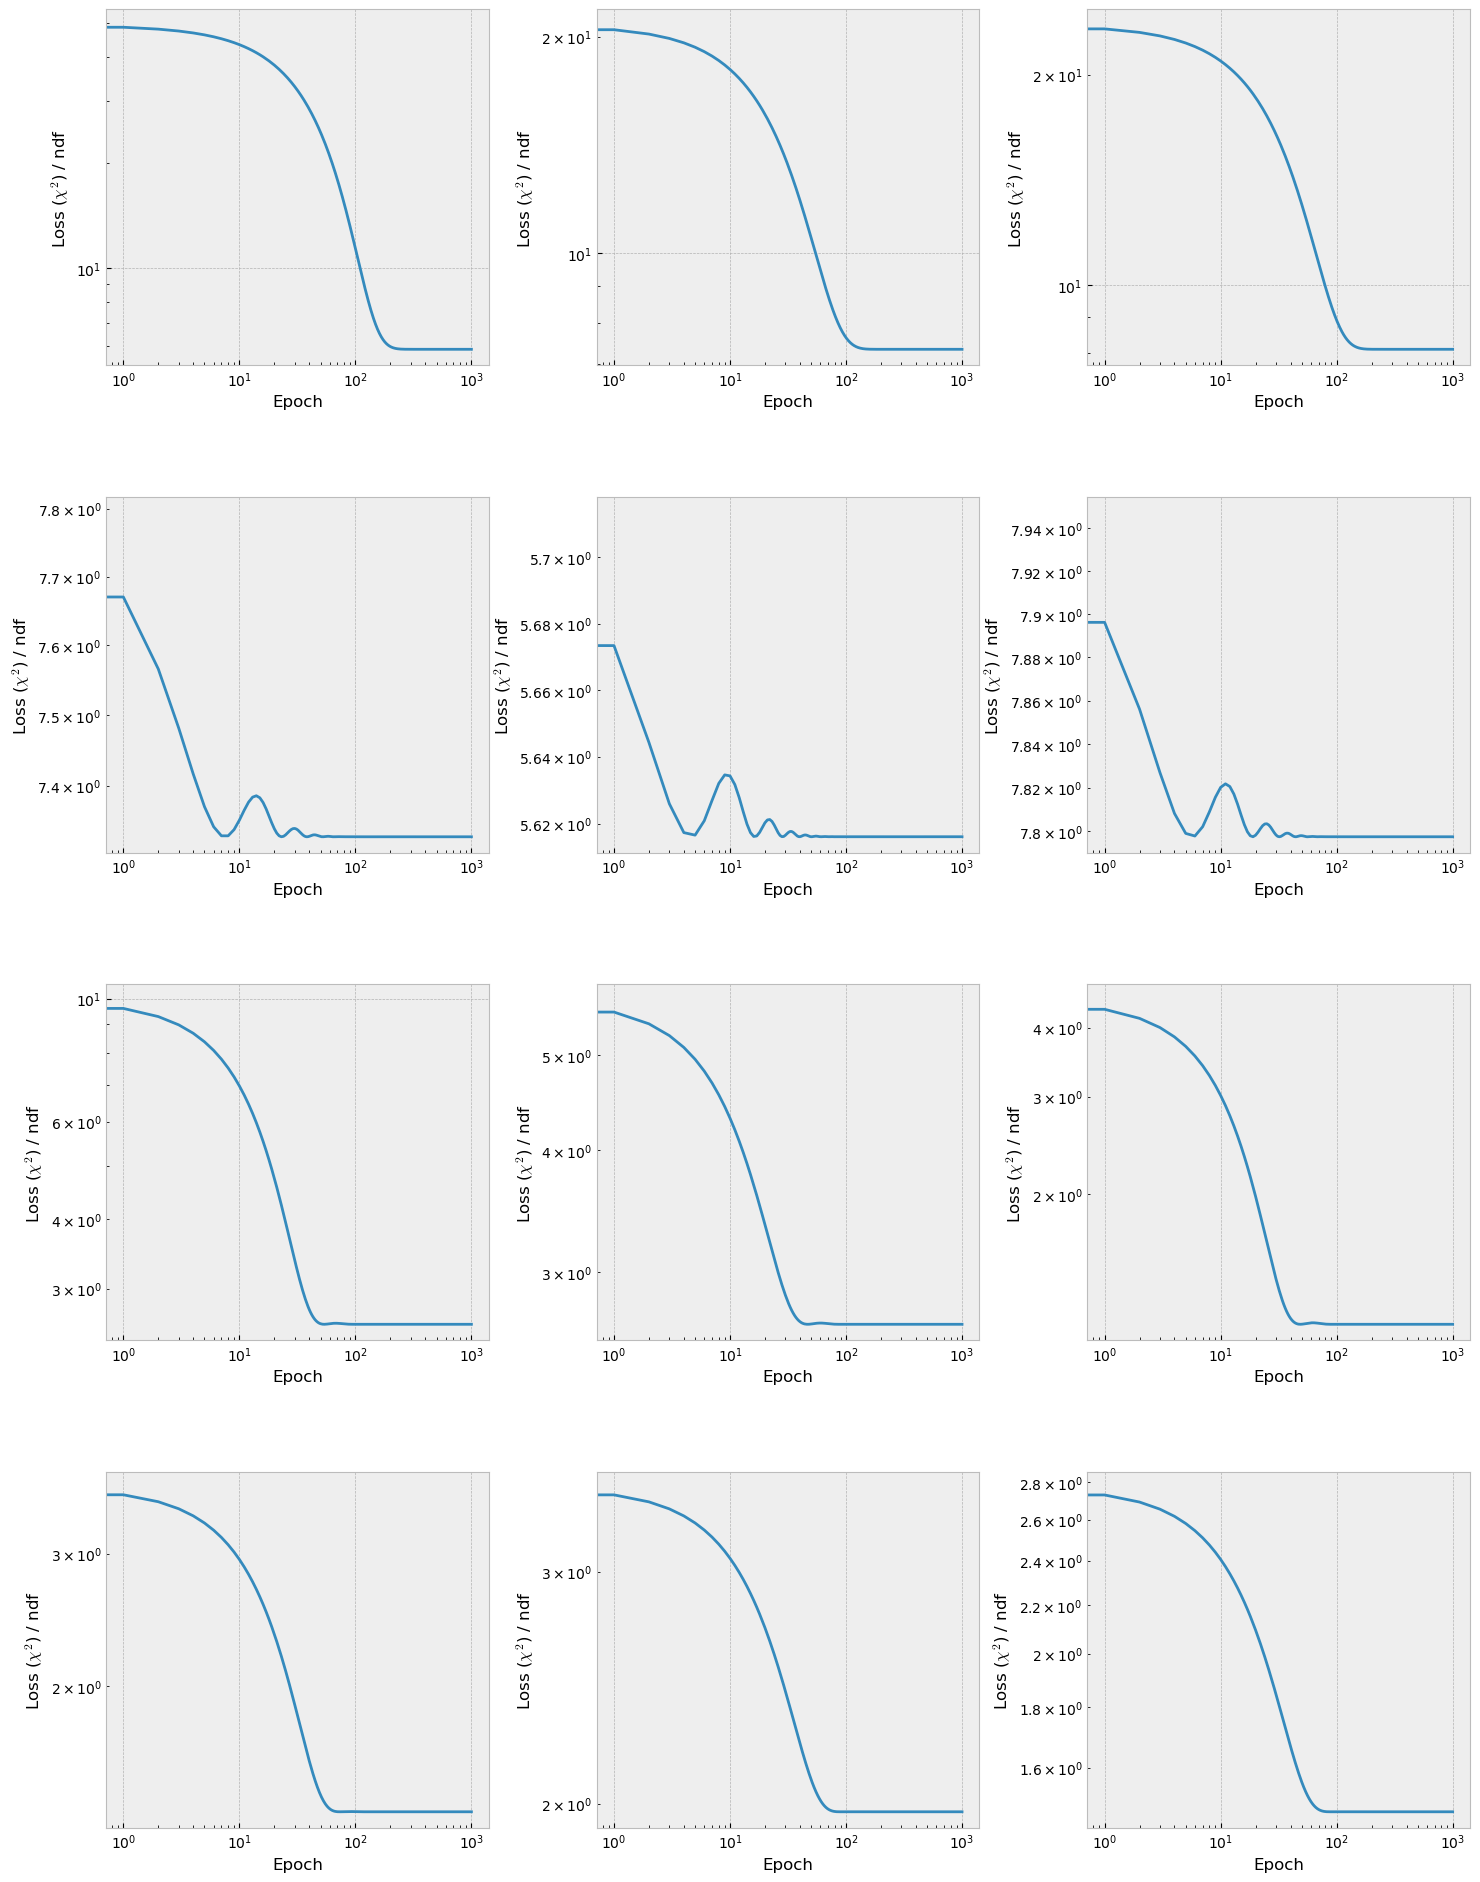

In [9]:
fig_np, ax_np = plot_losses(losses_all_np, range_used)

# Calculating covariance matrix for parameters

In general, if the value of the fitted model with $m$ parameters at point $x_i$ can be expressed as ({cite}`@cowan1998statistical`):
$$f(x_i,\mathbf{\lambda})=\sum_{j=1}^{m}a_j(x_i)\lambda_j\equiv\sum_{j=1}^{m}A_{ij}\lambda_j,$$
then the expression for $\chi^2$ is:
$$\chi^2=(\mathbf{y}-A\mathbf{\lambda})^T V^{-1}(\mathbf{y}-A\mathbf{\lambda}),$$
where $V$ is the covariance matrix of different data points. We have only statistical errors at each data point (histogram bin in our case), so we assume, witn $n$ data points (bins),
$$V^{-1}=\mathrm{diag}\left(\frac{1}{\sigma^2_{1}},\frac{1}{\sigma^2_{2}},\frac{1}{\sigma^2_{3}},...,\frac{1}{\sigma^2_{n}}\right).$$
The covariance matrix for for parameters, $U_{ij}=\mathrm{cov}[\hat{\lambda}_i,\hat{\lambda}_j]$ is calculated as
$$U=(A^TV^{-1}A)^{-1}.$$
In our case, the $i$-th row of matrix $A$, corresponding to the $i$-th data point (bin) has the following form:
$$\left(\frac{c_i}{I}\;\;\;\frac{c_i}{I}\cos^2(\theta_i)\;\;\;\frac{c_i}{I}\sin(2\theta_i)cos(\phi_i)\;\;\;\frac{c_i}{I}\sin^2(\theta_i)\cos(2\phi_i)\right),$$
where $\theta_i$, $\phi_i$ are values corresponding the bin center. Note, that one of the axes is $\cos(\theta)$, so $\arccos$ has to be calculated. $c_i$ is the bin content of the **unweighted** model histogram. $I$ is the integral of the model histogram **after applying the weights**. Thanks to that, the weighted histogram is always normalized to unity and can be compared to the experimental data histogram ($\mathbf{y}$) which is also normalized to unity all the time.

For the errors of the fit parameters, we just use square roots of the diagonal elements of the matrix $U$. However, with the matrix $A$ given above, we calculate the covariance matrix for the fit:
$$f(\theta,\phi)=A+B\cos^2(\theta_i)+C\sin(2\theta_i)cos(\phi_i)+D\sin^2(\theta_i)\cos(2\phi_i).$$
In order to get correct errors of the parameters of the fit:
$$f(\theta,\phi)\propto1+\lambda_\theta\cos^2(\theta_i)+\lambda_{\theta\phi}\sin(2\theta_i)cos(\phi_i)+\lambda_\phi\sin^2(\theta_i)\cos(2\phi_i),$$
we use error propagation to calculate the errors of ratios of ${B, C, D}$ parameters to $A$.

{bibliography}

Maybe covariance matrix:
tensor([[ 4.0724e-05, -1.8956e-04],
        [-1.8956e-04,  2.1698e-03]])
Compare:
Old: 0.2035505154291626, new: 0.006381520506667385
Old: 0.6228362380305813, new: 0.046580719579467224
Old: 0.6257350662050681, new: 0.046618889886732795, new/old: 0.07450260086823181
Maybe covariance matrix:
tensor([[ 4.8857e-05, -2.4178e-04],
        [-2.4178e-04,  2.9477e-03]])
Compare:
Old: 0.23664094160115212, new: 0.00698974678868641
Old: 0.7240883351246958, new: 0.05429313873224884
Old: 0.7247409104984683, new: 0.054300734744863834, new/old: 0.07492434048950876
Maybe covariance matrix:
tensor([[ 8.7278e-05, -3.7403e-04],
        [-3.7403e-04,  3.5427e-03]])
Compare:
Old: 0.41532350264584983, new: 0.00934229251408894
Old: 1.2708320949629217, new: 0.05952078487933415
Old: 1.2708934779332797, new: 0.0595214480257106, new/old: 0.046834332742429416
Maybe covariance matrix:
tensor([[ 1.8673e-05, -4.6753e-05],
        [-4.6753e-05,  2.7044e-04]])
Compare:
Old: 0.014595702838968383,

Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_0_np.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_0_np.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/comparison_2.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_0_np.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_3_np.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_3_np.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/comparison_5.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_3_np.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_6_np.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_6_np.gif has been created
Info in <TCanvas::Print>: gif 

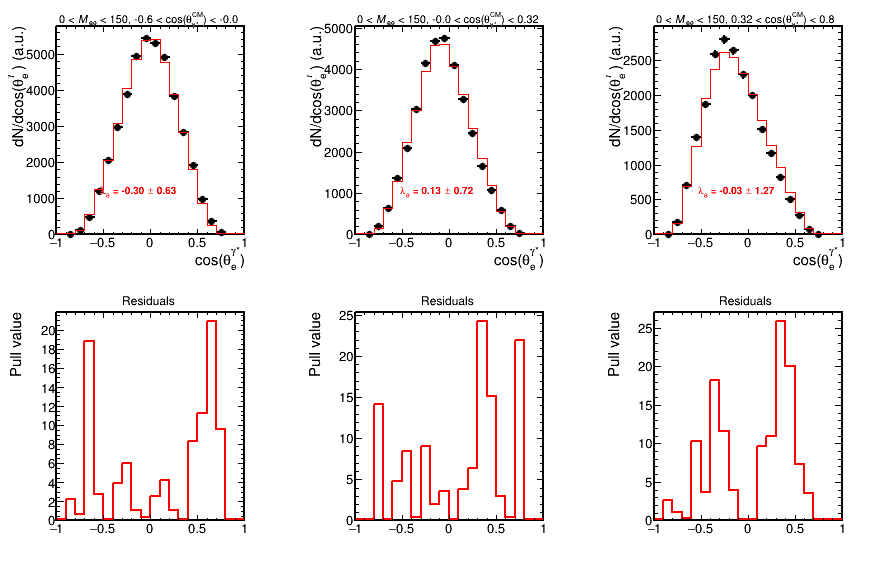

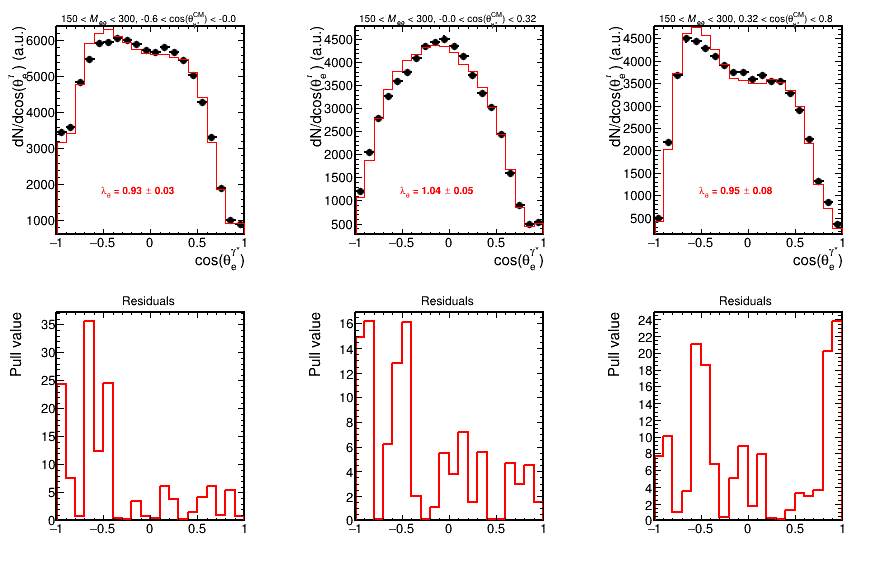

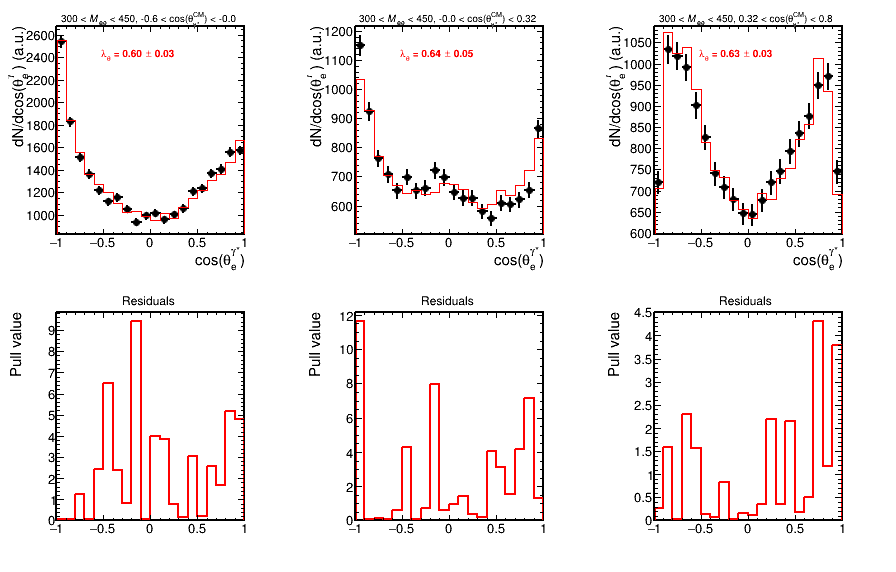

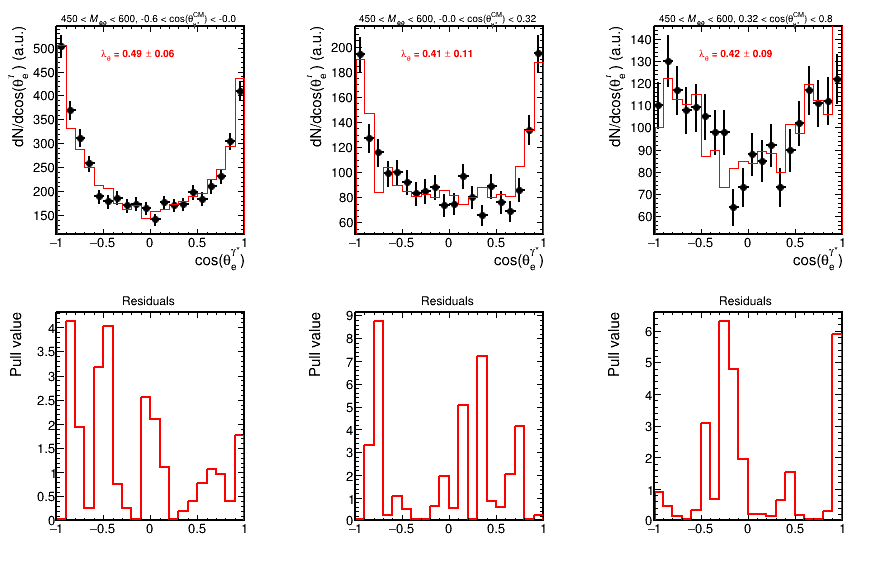

In [10]:
df_np = show_results("np", DIR_NAME, range_used, parameters_all_np, get_hist_maker_mc, bins, histsData_np, analyse_3d)

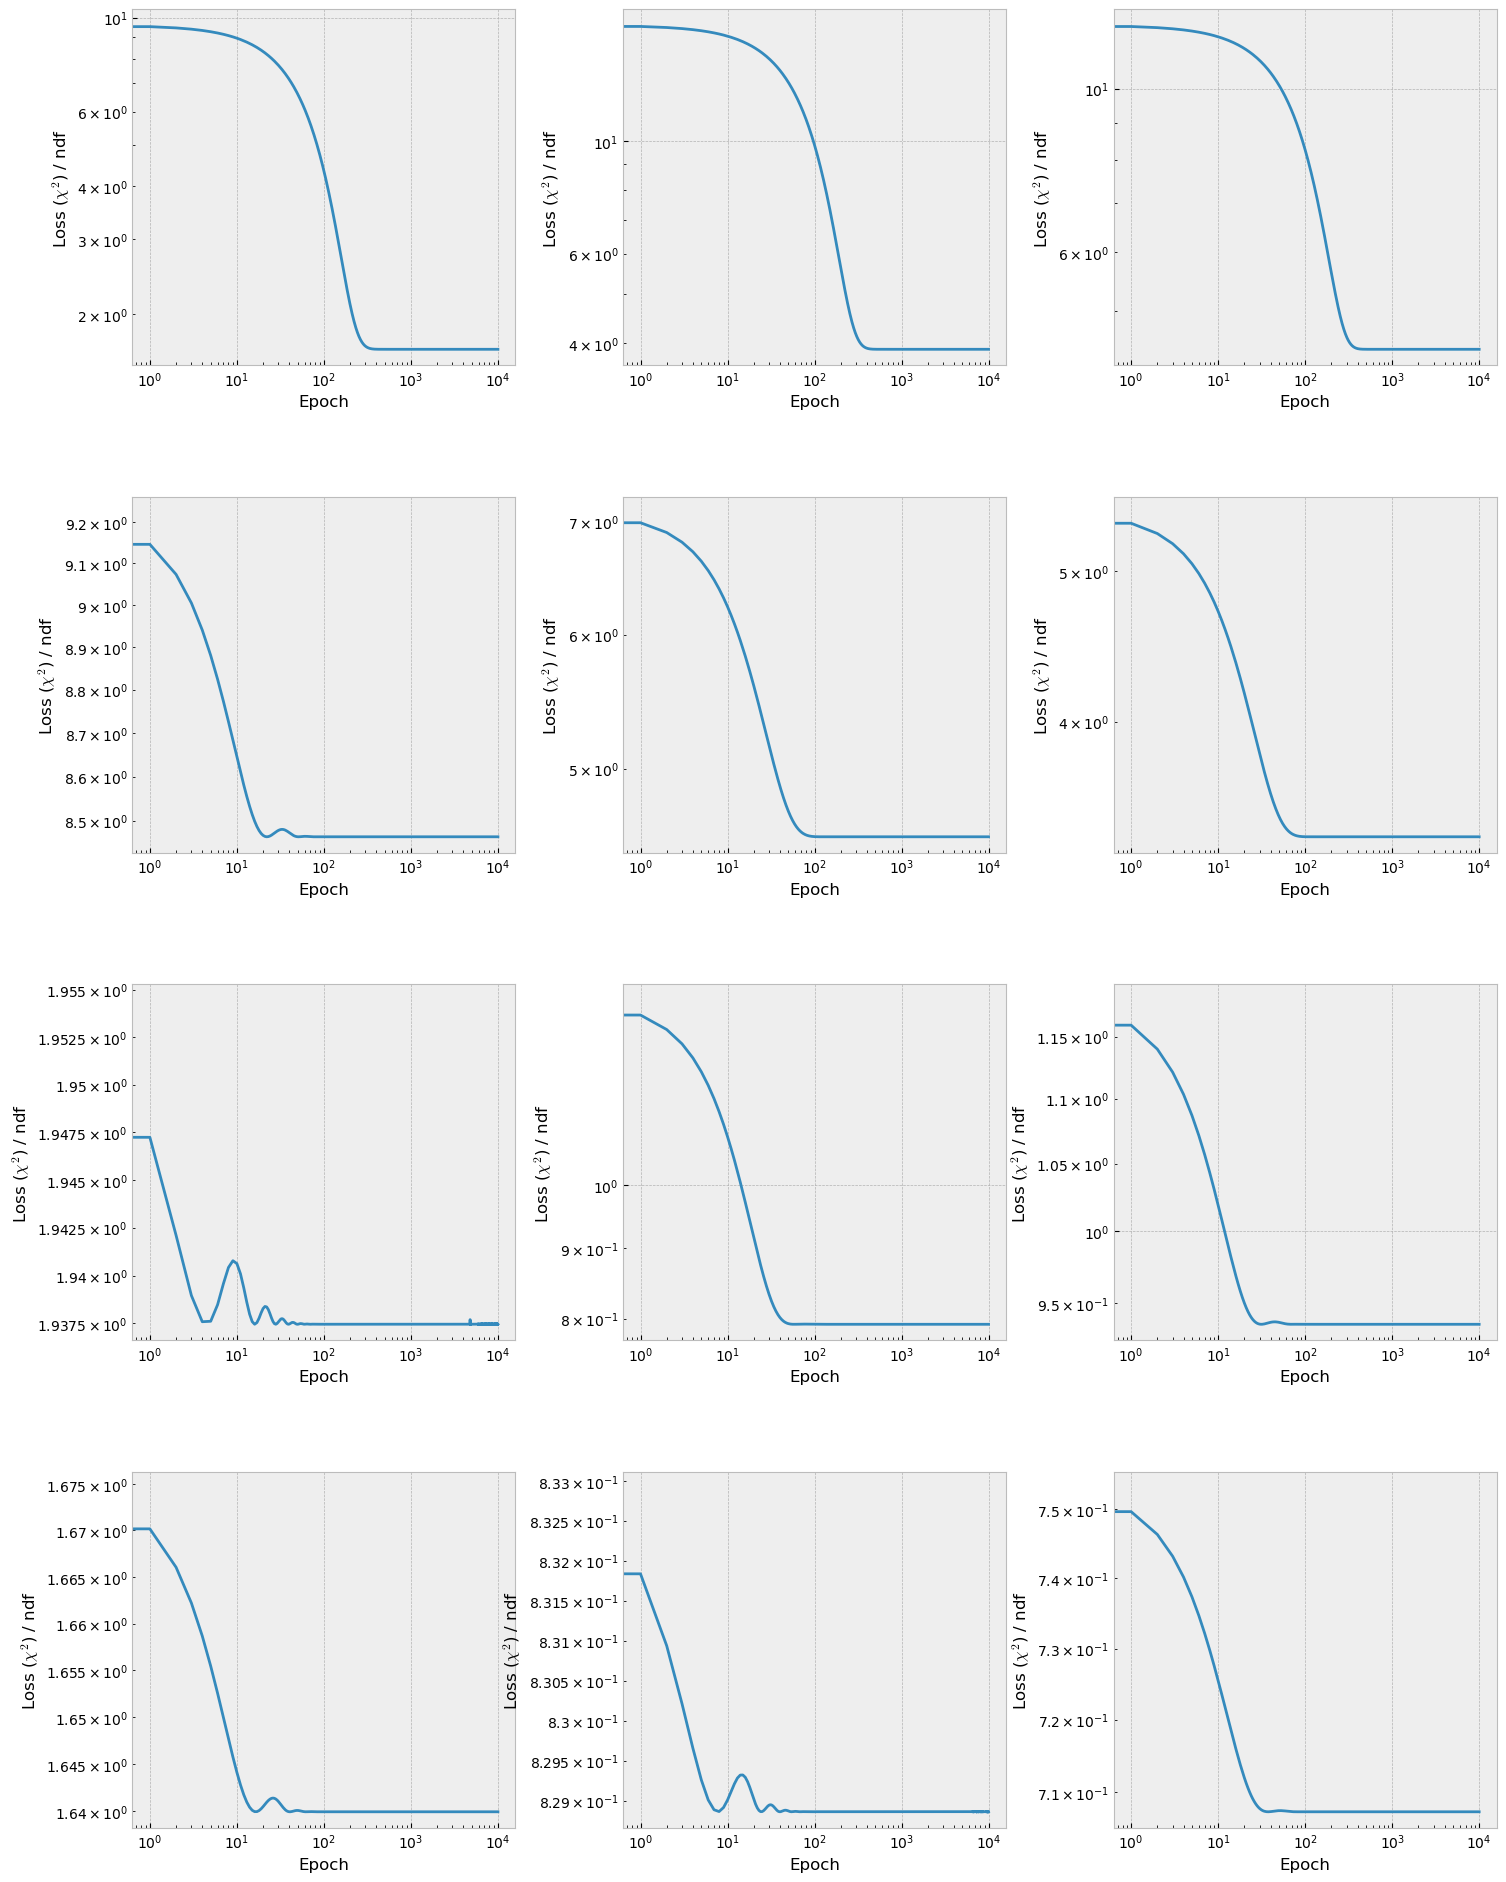

In [11]:
fig_pp, ax_pp = plot_losses(losses_all_pp, range_used)

Maybe covariance matrix:
tensor([[ 0.0008, -0.0034],
        [-0.0034,  0.0343]])
Compare:
Old: 3.4879787581143256, new: 0.028755309442965553
Old: 10.672729388349467, new: 0.18521130986569878
Old: 11.277170561525482, new: 0.18762983818192516, new/old: 0.01663802433050584
Maybe covariance matrix:
tensor([[ 0.0012, -0.0047],
        [-0.0047,  0.0406]])
Compare:
Old: 1.606542358483794, new: 0.03512991806531998
Old: 5.248170087190873, new: 0.20150918366314685
Old: 5.822335633721488, new: 0.20891447441288602, new/old: 0.03588155811611177
Maybe covariance matrix:
tensor([[ 0.0039, -0.0136],
        [-0.0136,  0.0895]])
Compare:
Old: 1.1629207496644334, new: 0.06258589832017544
Old: 4.555994471625814, new: 0.2991895671388175
Old: 4.962780412800552, new: 0.31737896719470565, new/old: 0.06395184569844894
Maybe covariance matrix:
tensor([[ 6.6792e-05, -2.0459e-04],
        [-2.0459e-04,  1.4506e-03]])
Compare:
Old: 0.04963485619555992, new: 0.00817263968577437
Old: 0.10621213101348474, new: 0.0

Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_0_pp.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_0_pp.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/comparison_2.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_0_pp.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_3_pp.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_3_pp.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/comparison_5.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_3_pp.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_6_pp.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_6_pp.gif has been created
Info in <TCanvas::Print>: gif 

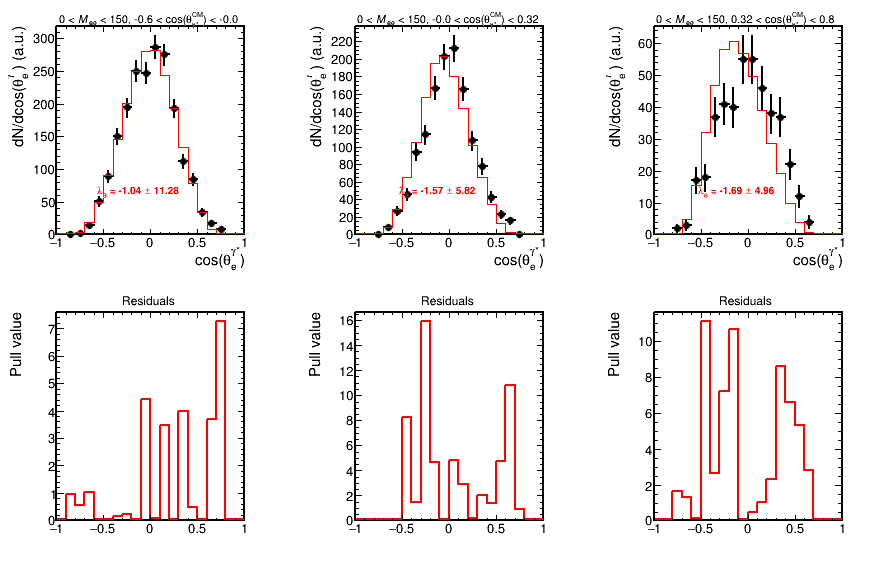

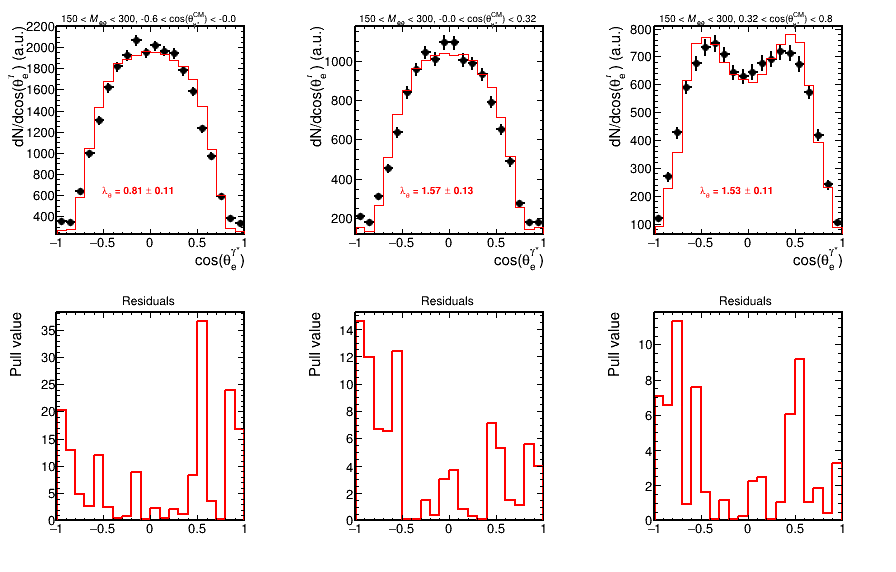

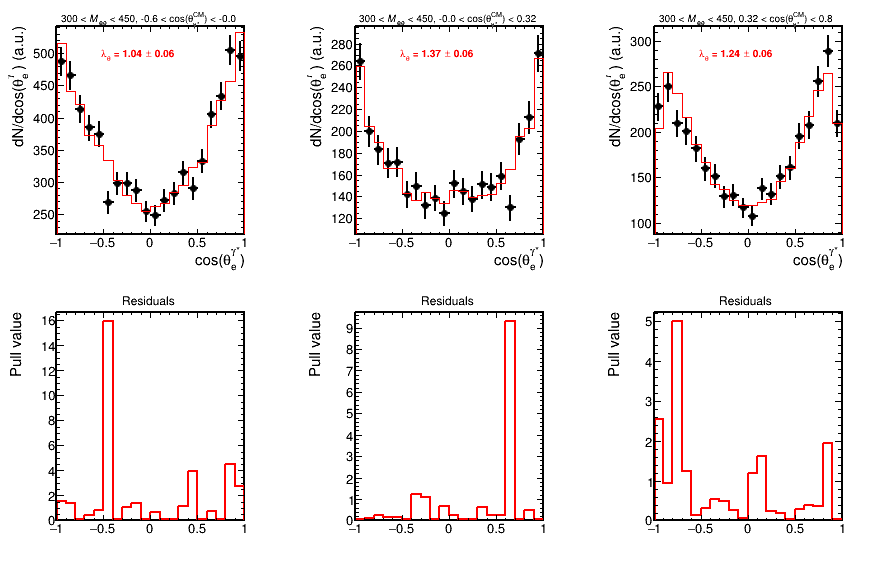

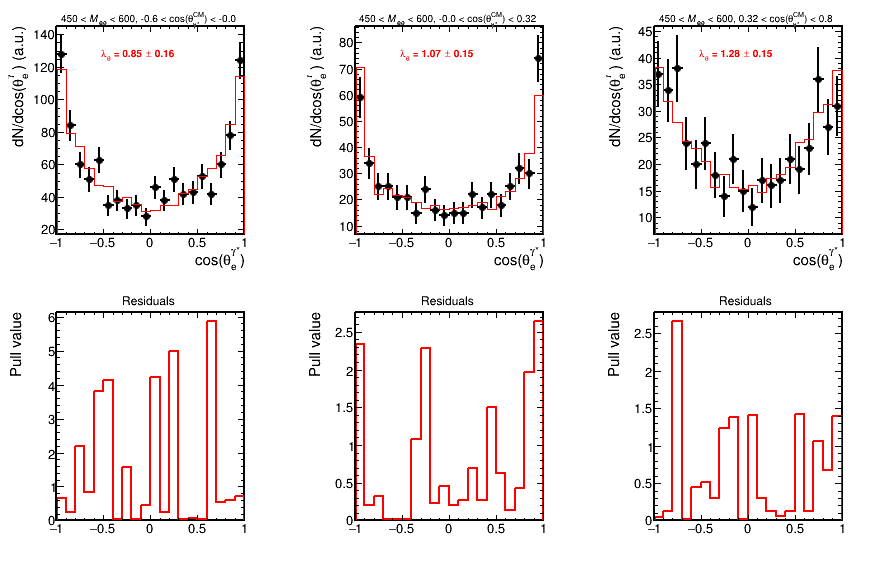

In [12]:
df_pp = show_results("pp", DIR_NAME, range_used, parameters_all_pp, get_hist_maker_mc, bins, histsData_pp, analyse_3d)

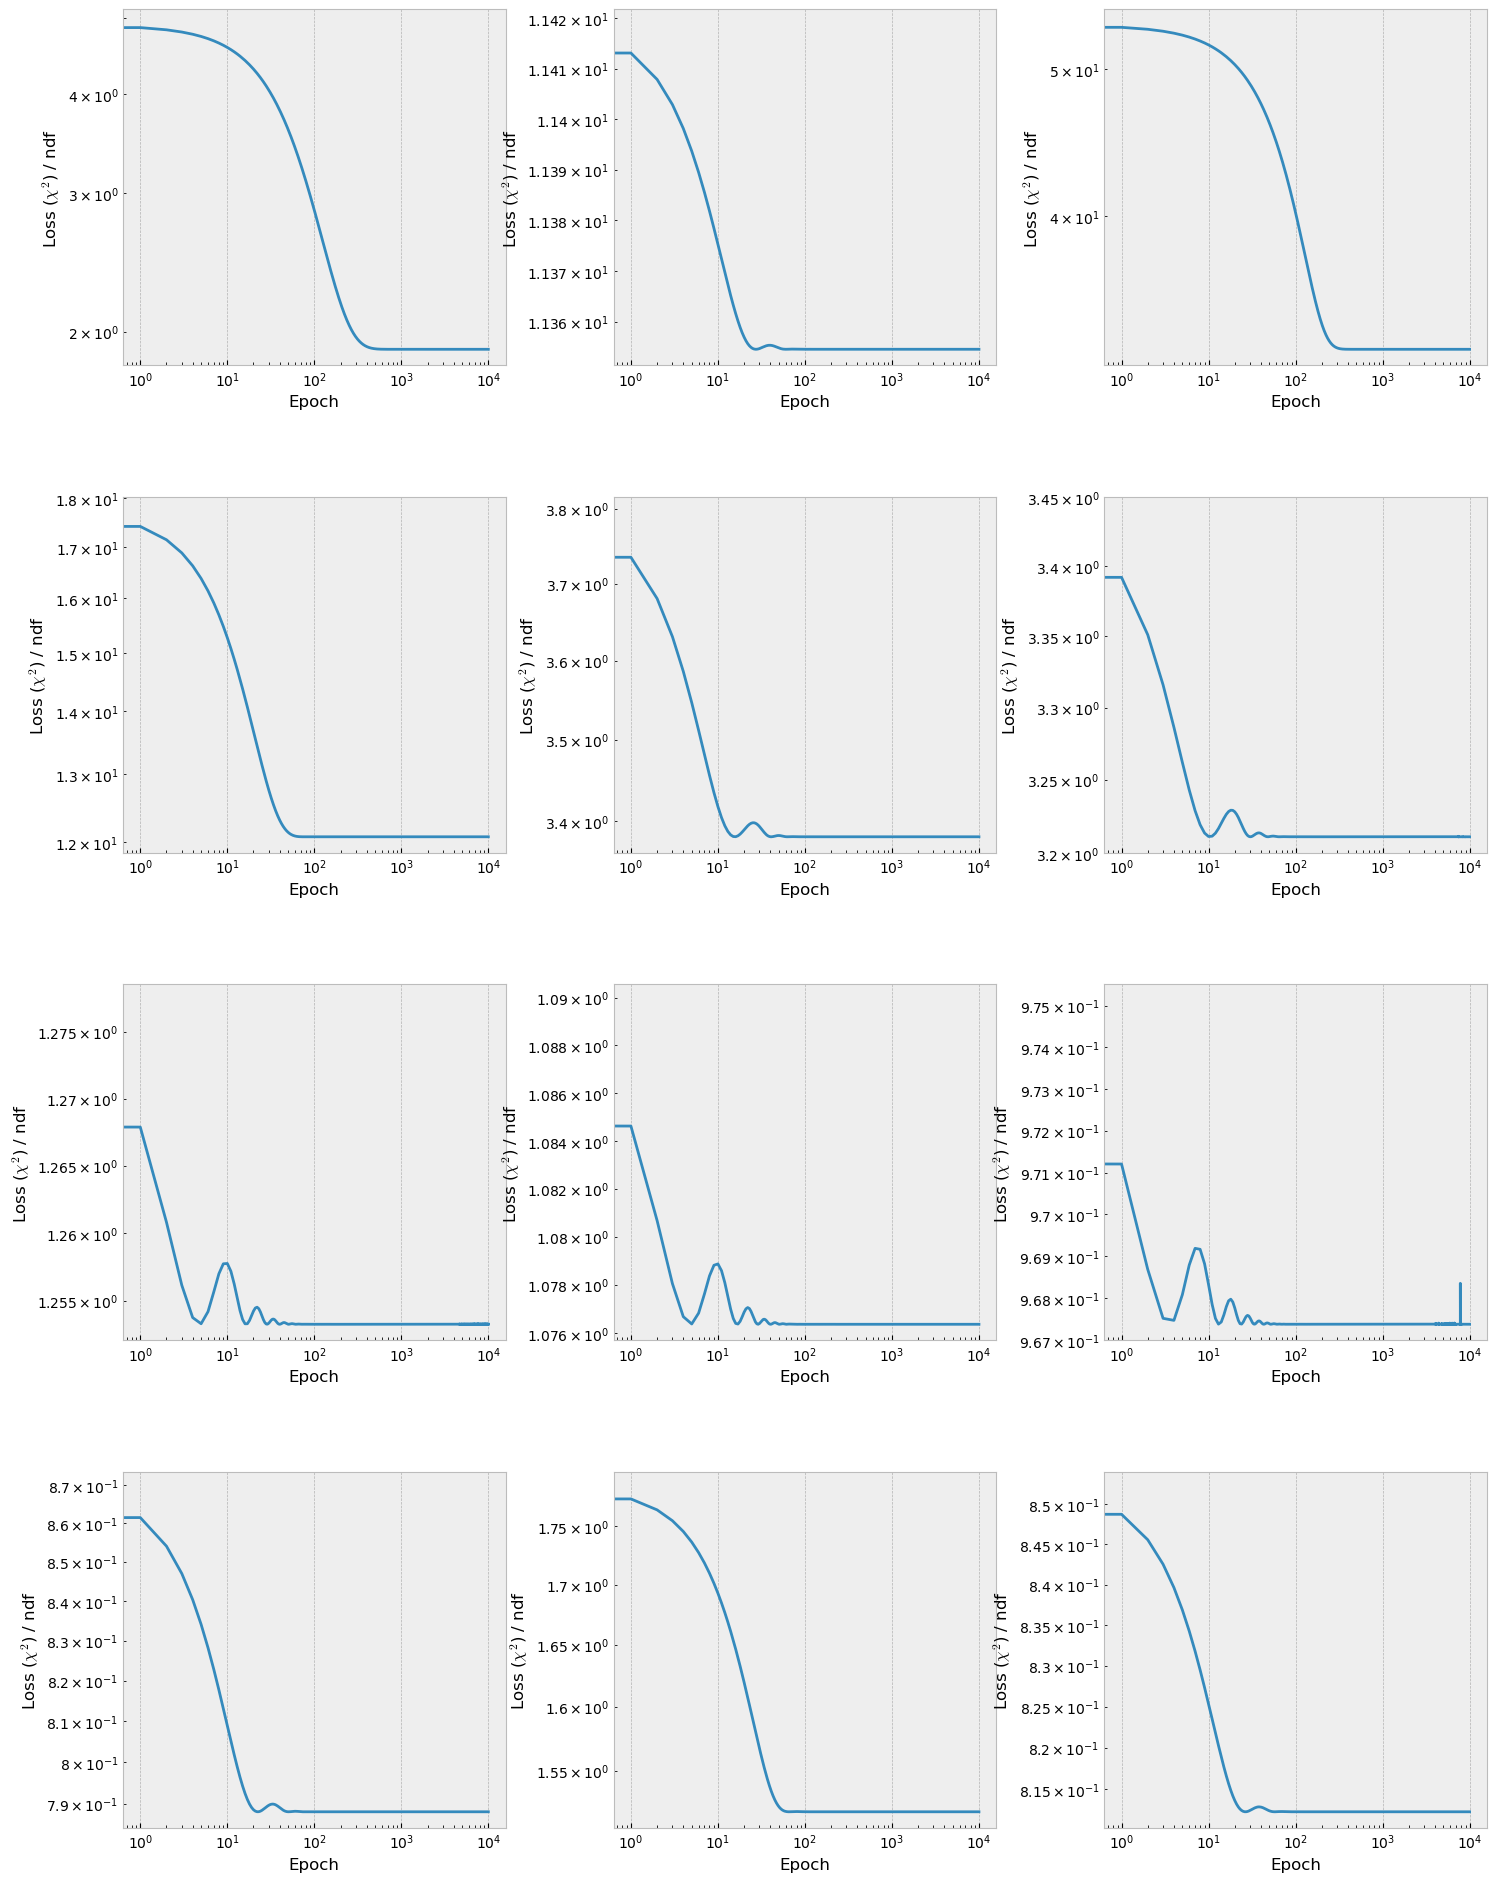

In [13]:
fig_nn, ax_nn = plot_losses(losses_all_nn, range_used)

Maybe covariance matrix:
tensor([[ 0.0006, -0.0034],
        [-0.0034,  0.0536]])
Compare:
Old: 0.5199025012322253, new: 0.02484237588937519
Old: 1.3600746332457523, new: 0.23142302683481222
Old: 2.155052267114322, new: 0.24482009136704555, new/old: 0.11360285553299679
Maybe covariance matrix:
tensor([[ 0.0005, -0.0027],
        [-0.0027,  0.0352]])
Compare:
Old: 1.8603721809463813, new: 0.022899293110703864
Old: 4.866768299256678, new: 0.18751272515984704
Old: 5.075854860905181, new: 0.18835072027792557, new/old: 0.0371071918798594
Maybe covariance matrix:
tensor([[ 0.0005, -0.0019],
        [-0.0019,  0.0152]])
Compare:
Old: 6.283960079983289, new: 0.02194886310131926
Old: 20.52811813315319, new: 0.12344194748266316
Old: 21.667571382503237, new: 0.12579541751546525, new/old: 0.00580569992339087
Maybe covariance matrix:
tensor([[ 5.1716e-05, -1.2449e-04],
        [-1.2449e-04,  6.5363e-04]])
Compare:
Old: 0.031998765009873927, new: 0.0071913880749149795
Old: 0.06847319166409647, new: 

Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_0_nn.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_0_nn.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/comparison_2.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_0_nn.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_3_nn.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_3_nn.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/comparison_5.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_3_nn.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_6_nn.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_6_nn.gif has been created
Info in <TCanvas::Print>: gif 

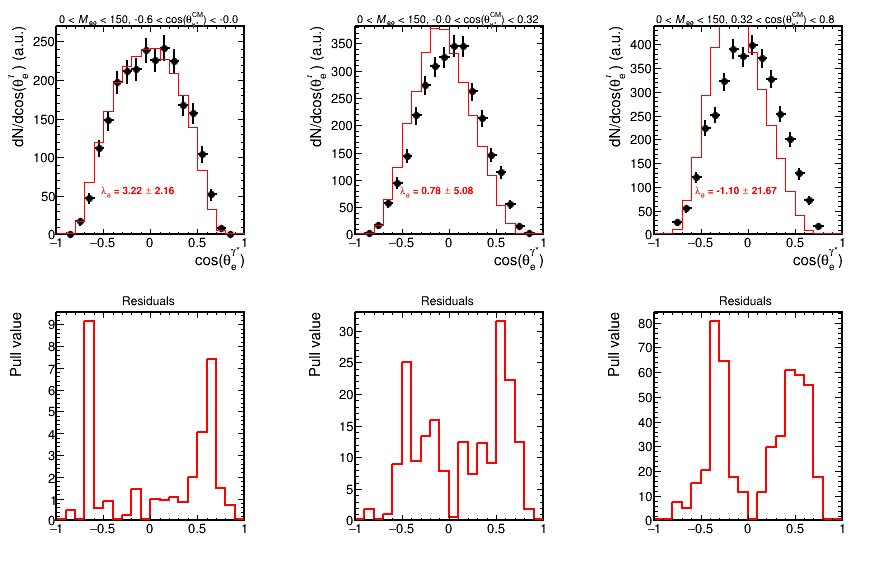

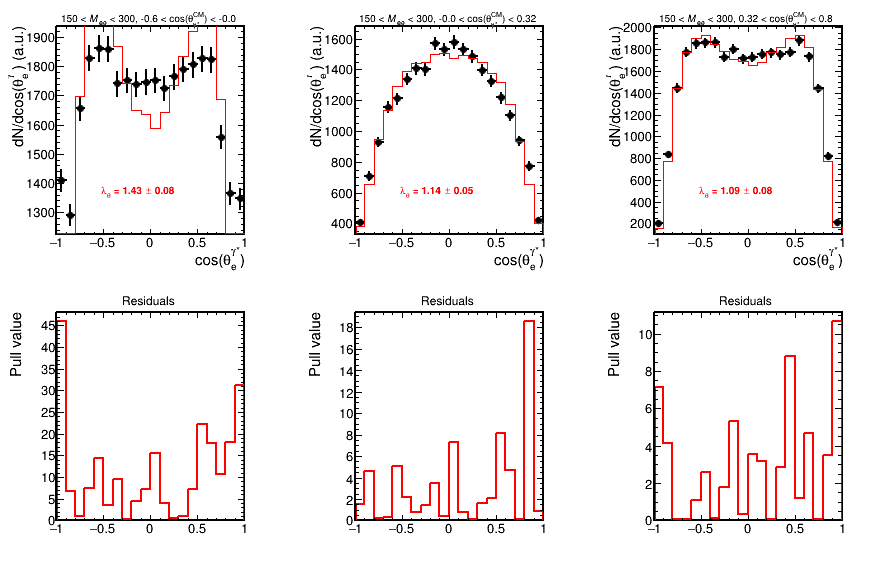

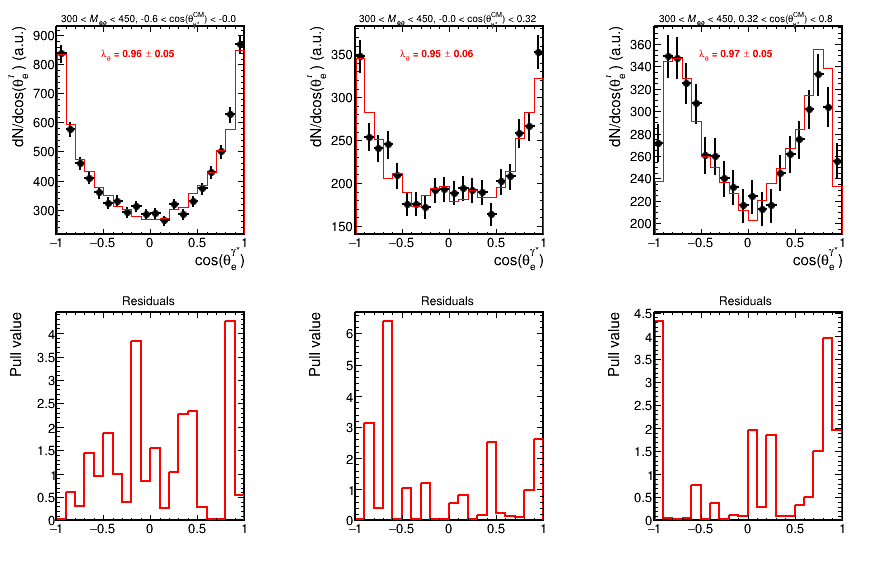

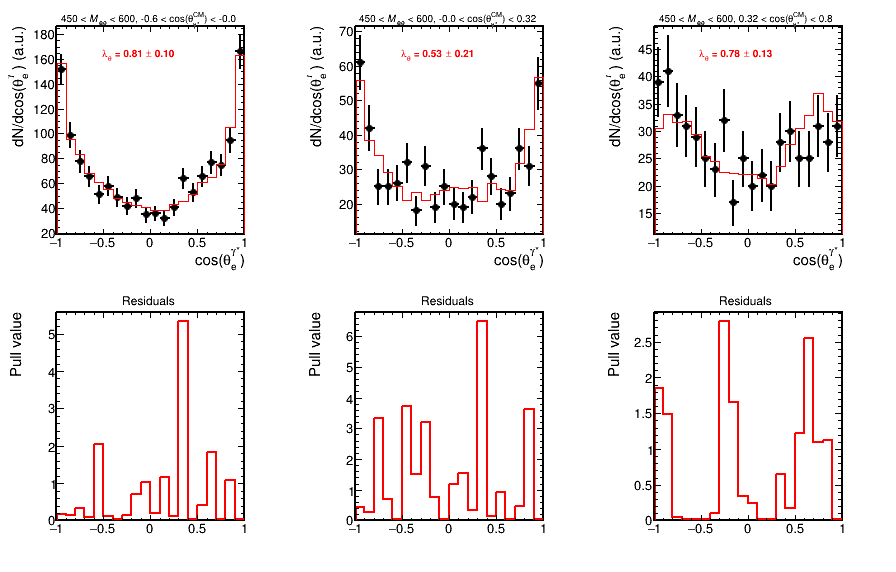

In [14]:
df_nn = show_results("nn", DIR_NAME, range_used, parameters_all_nn, get_hist_maker_mc, bins, histsData_nn, analyse_3d)

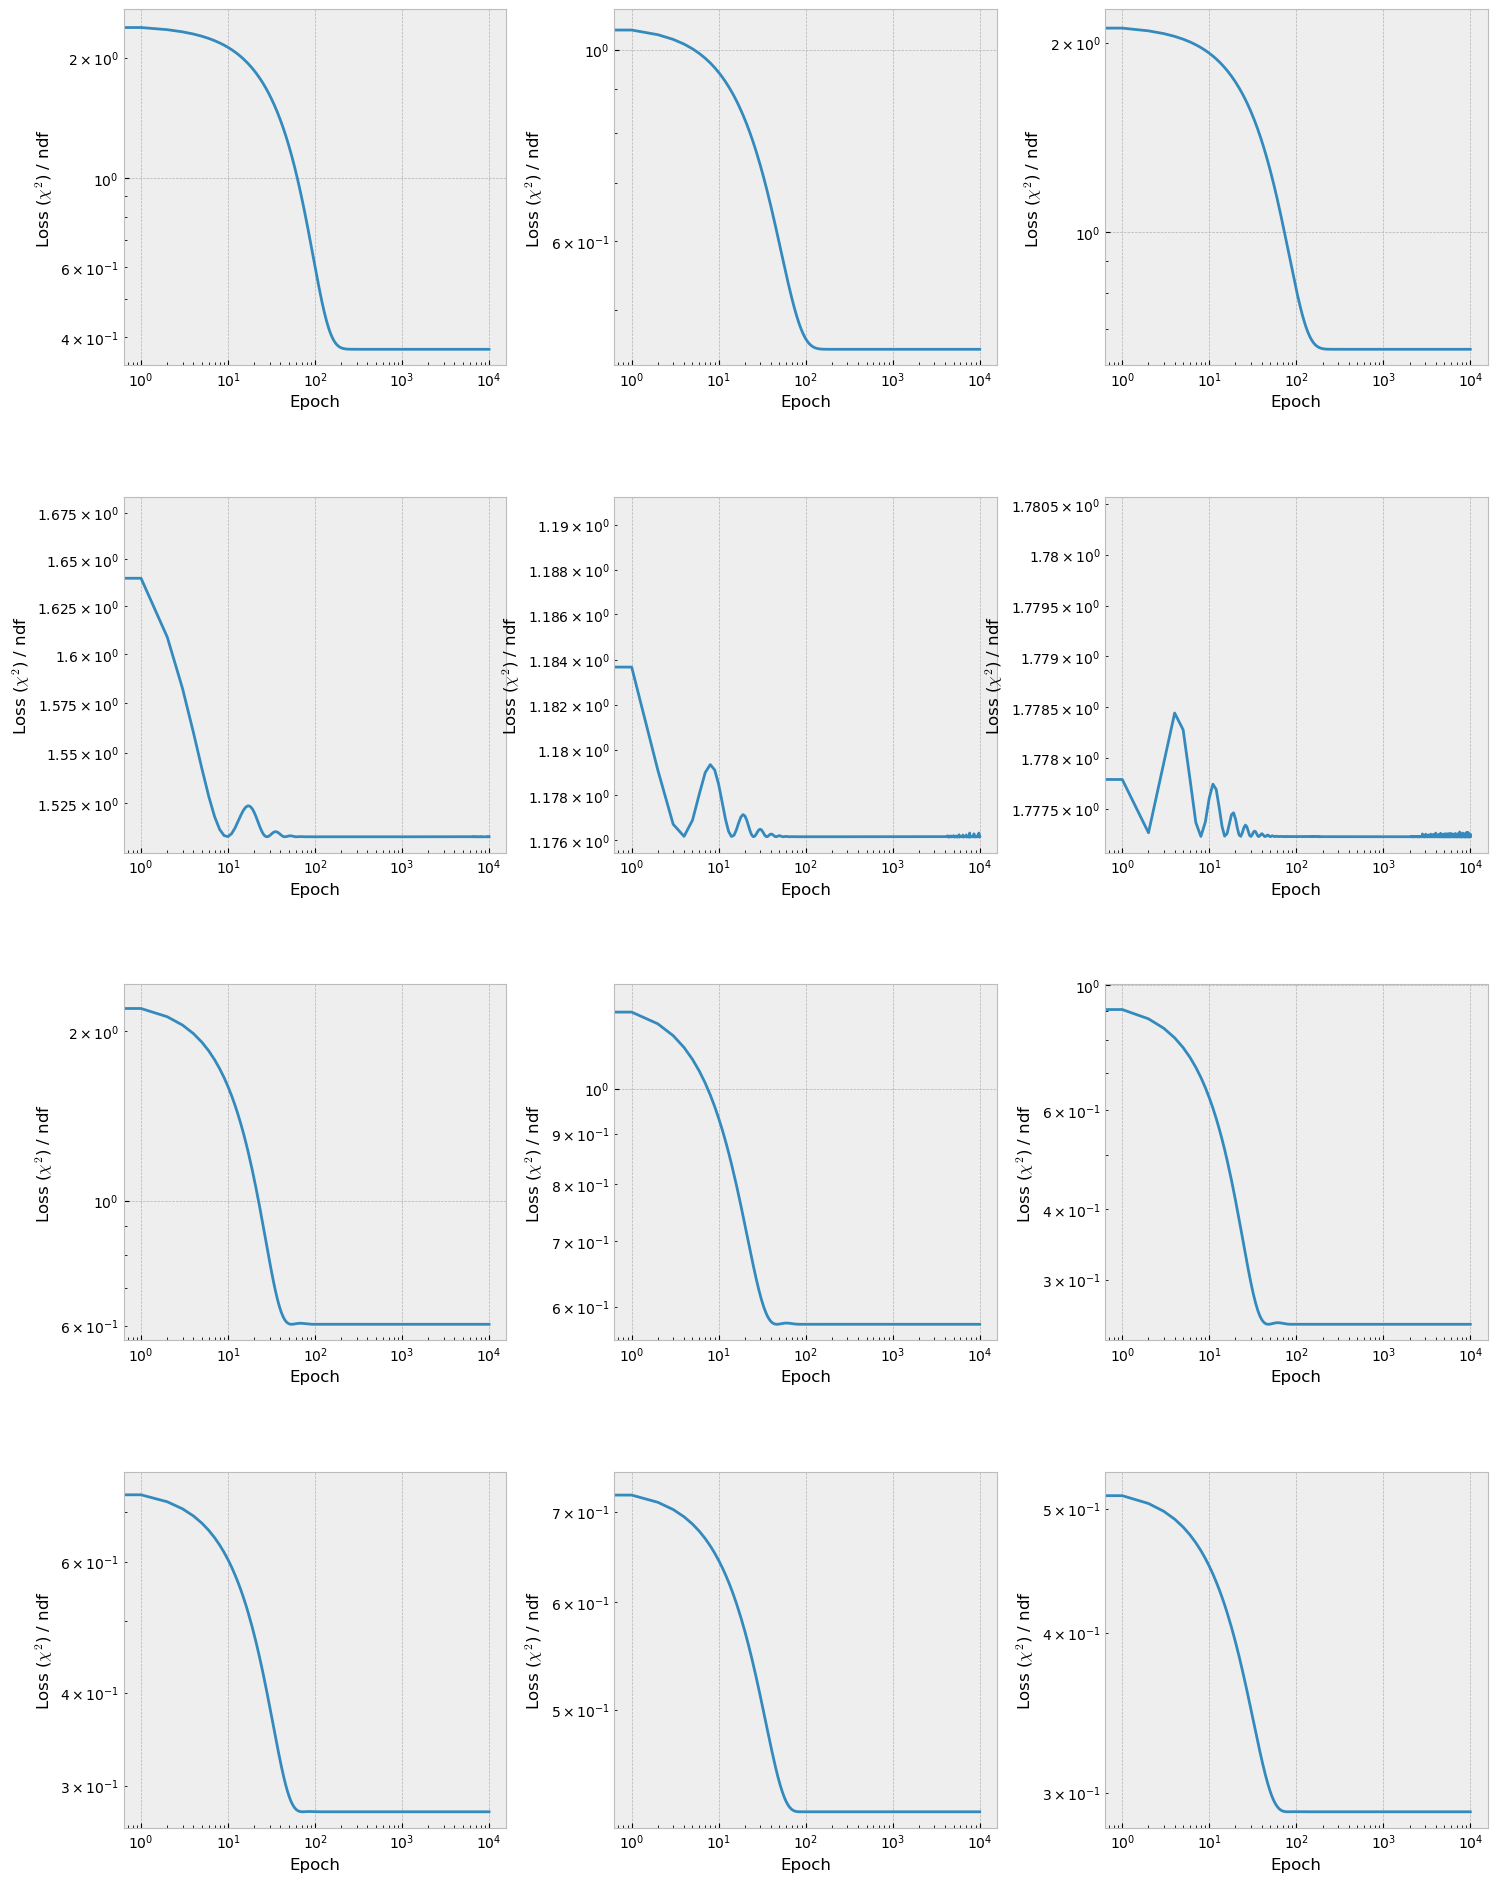

In [15]:
fig_sig, ax_sig = plot_losses(losses_all_sig, range_used)

Maybe covariance matrix:
tensor([[ 0.0009, -0.0039],
        [-0.0039,  0.0423]])
Compare:
Old: 0.19089095217577087, new: 0.0293666059419818
Old: 0.5840997369943228, new: 0.20572494953195228
Old: 0.5859378572131678, new: 0.20584861916571254, new/old: 0.3513147625326136
Maybe covariance matrix:
tensor([[ 0.0009, -0.0048],
        [-0.0048,  0.0646]])
Compare:
Old: 0.23672828159511625, new: 0.030670291274085403
Old: 0.7243555833463745, new: 0.2541439117866416
Old: 0.7250027152527191, new: 0.2541748836914519, new/old: 0.3505847334693808
Maybe covariance matrix:
tensor([[ 0.0015, -0.0062],
        [-0.0062,  0.0585]])
Compare:
Old: 0.04167684149954386, new: 0.03840727685674175
Old: 0.13614776587212388, new: 0.24182944594543332
Old: 0.13648149424772138, new: 0.24198915166748242, new/old: 1.773054676762689
Maybe covariance matrix:
tensor([[ 7.8766e-05, -2.0688e-04],
        [-2.0688e-04,  1.2791e-03]])
Compare:
Old: 0.014984295995798695, new: 0.00887500325078741
Old: 0.032064442841943284, ne

Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_0_sig.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_0_sig.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/comparison_2.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_0_sig.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_3_sig.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_3_sig.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/comparison_5.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_3_sig.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_6_sig.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_cmp_6_sig.gif has been created
Info in <TCanvas::Prin

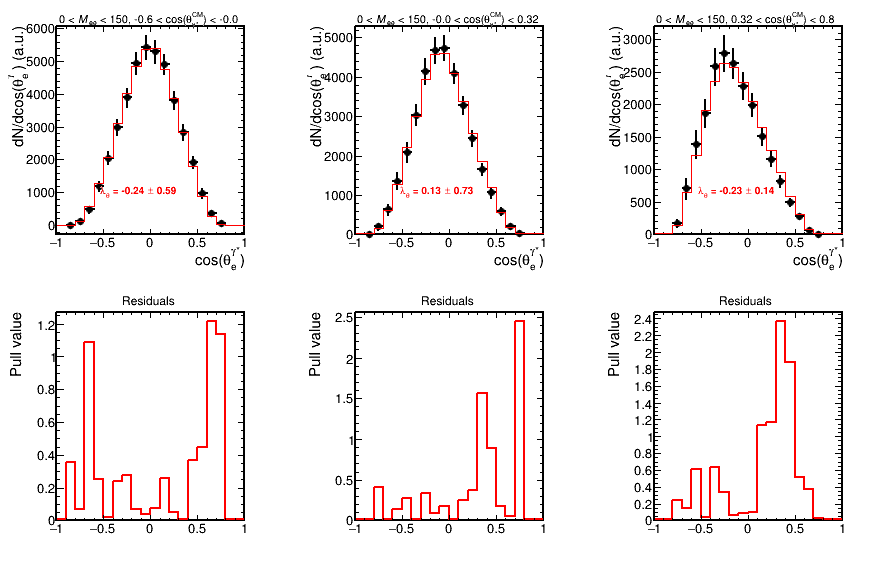

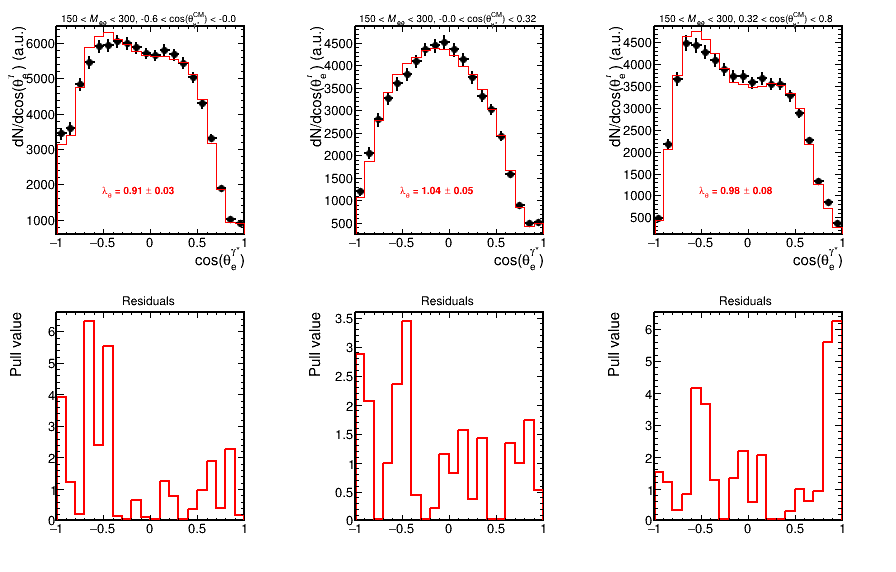

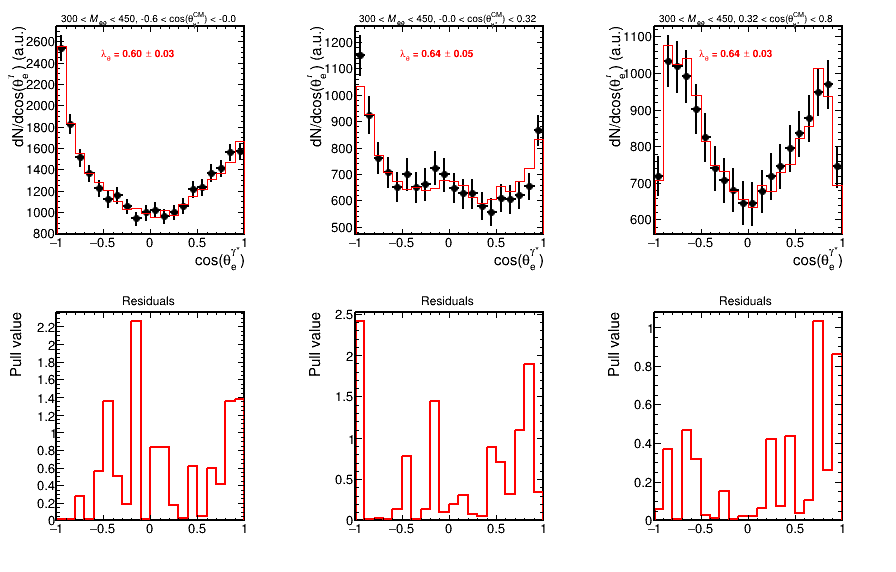

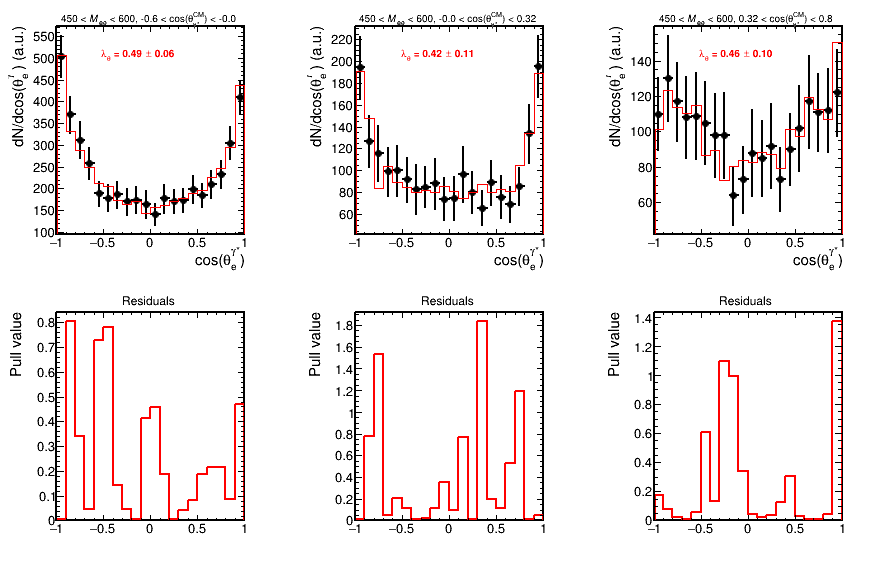

In [16]:
df_sig = show_results("sig", DIR_NAME, range_used, parameters_all_sig, get_hist_maker_mc, bins, histsData_sig, analyse_3d)


Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_m06p00_data_pp_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_m06p00_data_pp_mix_iter11 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_m06p00_data_pp_iter2_corr (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p00p03_data_pp_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p00p03_data_pp_mix_iter11 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p00p03_data_pp_iter2_corr (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p03p08_data_pp_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p03p08_data_pp_mix_iter11 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p03p08_data_pp_iter2_corr (Pote

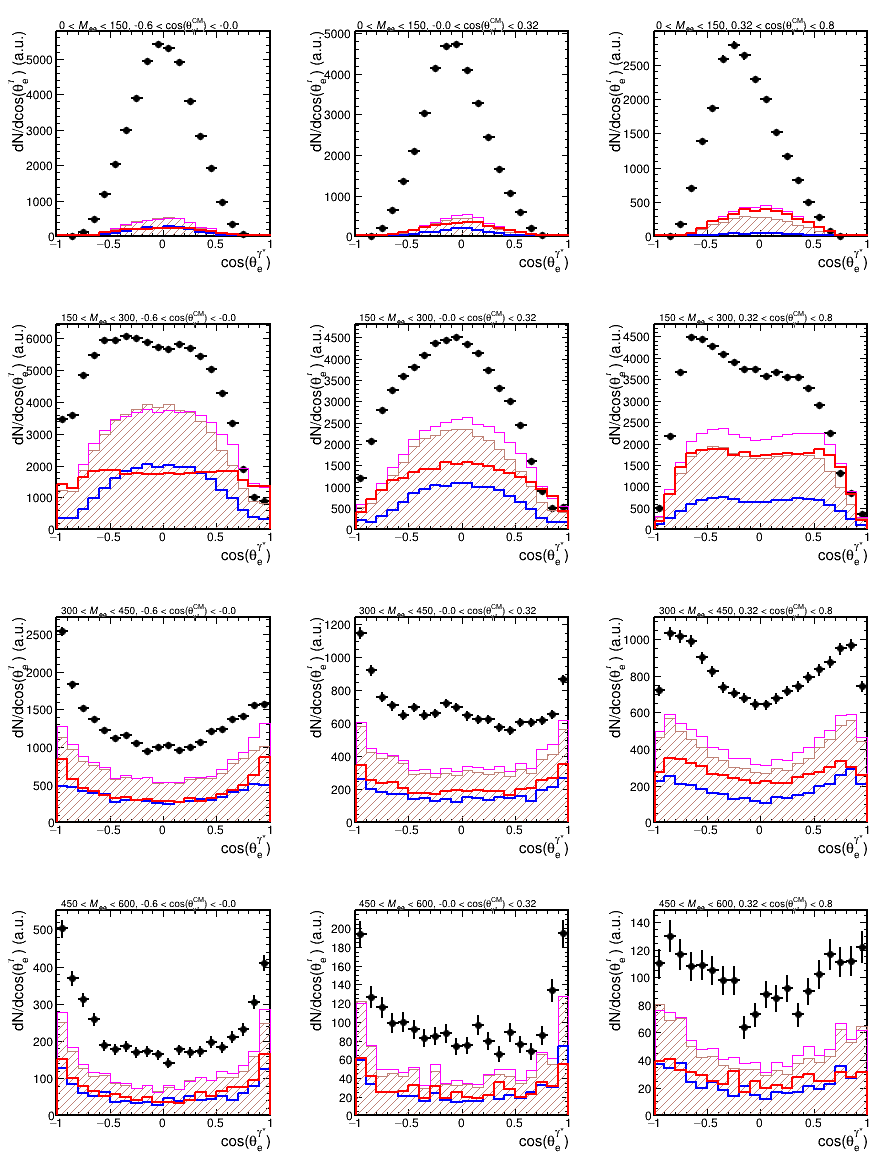

In [17]:

if not analyse_3d:
    histsDataCorrs = []
    histsDatas = []
    histsModels = []
    legends = []
    hmodel_null = histMakerMC_rho_heli0_np.make_hists((0.0))
    hmodel_null_pp = histMakerMC_rho_heli0_pp.make_hists((0.0))
    hmodel_null_nn = histMakerMC_rho_heli0_nn.make_hists((0.0))
    hmodel_null_mix = histMakerMC_mix.make_hists((0.0))
    hmodel_null_pi0 = histMakerMC_pi0.make_hists((0.0))
    hmodel_null_heli1 = histMakerMC_rho_heli1.make_hists((0.0))

    pol2s = []
    histsAvg = []
    kfactors = []

    cc4 = TCanvas("cc4","cc4",900,1200)
    cc4.Divide(3,4)
    cc4.Draw()

    cck = TCanvas("cck","cck",900,1200)
    cck.Divide(3,4)

    csig = TCanvas("csig","csig",900,1200)
    csig.Divide(3,4)

    cacc = TCanvas("cacc","cacc",900,1200)
    cacc.Divide(3,4)

    for i, hist_np in enumerate(histsData_np[0]):
    
        if not isinstance(hist_np, list):

            hist_pp = histsData_pp[0][i]
            hist_nn = histsData_nn[0][i]
        
            if symmetrize_explicit:
                symmetrize(hist_np)
                symmetrize(hist_pp)
                symmetrize(hist_nn)
        
            histAvg = geom_avg1d(hist_pp, hist_nn, 0.2)
            histsAvg.append(histAvg)

        
            histCorr_np = hist_np.Clone(hist_np.GetName() + "_corr")
            histCorr_pp = hist_pp.Clone(hist_pp.GetName() + "_corr")
            histCorr_nn = hist_nn.Clone(hist_nn.GetName() + "_corr")
            histsDataCorrs.append(histCorr_np)
            histsDataCorrs.append(histCorr_pp)
            histsDataCorrs.append(histCorr_nn)
            histCorr_np.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        
            pad = cc4.cd(i+1)
            set_pad(pad)       
       
            hist_kfactor = histsData_np_mix[0][i]
            hist_pp_mix = histsData_pp_mix[0][i]
            hist_nn_mix = histsData_nn_mix[0][i]

            if symmetrize_explicit:
                symmetrize(hist_kfactor)
                symmetrize(hist_pp_mix)
                symmetrize(hist_nn_mix)

            histAvg_mix = geom_avg1d(hist_pp_mix, hist_nn_mix, 0.2)
            hist_kfactor.Divide(histAvg_mix)
            hist_kfactor.Scale(2)
            kfactors.append(hist_kfactor)

            pad = cck.cd(i+1)
            set_pad(pad)

            hist_kfactor.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        
            set_th1(hist_kfactor, histCorr_np.GetXaxis().GetTitle(), "#it{k}-factor", 
                   505, 20, 0.8, 1)
            hist_pp_mix.SetLineColor(2)
            hist_nn_mix.SetLineColor(4)
            hist_pp_mix.SetMarkerColor(2)
            hist_nn_mix.SetMarkerColor(4)
            hist_kfactor.Draw()
            hist_pp_mix.Draw("SAME")
            hist_nn_mix.Draw("SAME")
            hist_kfactor.SetMinimum(0)
             
            pad = cc4.cd(i+1)
            set_pad(pad)       
            
            histAvg_withK = histAvg.Clone(histAvg.GetName() + "_withK")
            histsAvg.append(histAvg_withK)
            histAvg_withK.Multiply(hist_kfactor)
            
            histAvg_withK.SetFillStyle(3004)
            histAvg_withK.SetFillColor(45)
            histAvg_withK.SetLineColor(45)
            histAvg.SetLineColor(6)
            hist_pp.SetLineColor(4)
            hist_nn.SetLineColor(2)
                    
            set_th1(hist_np, histCorr_np.GetXaxis().GetTitle(), f"dN/d{histCorr_np.GetXaxis().GetTitle()} (a.u.)", 
                   505, 20, 0.8, 1)
            hist_np.SetMinimum(0)
            hist_np.Draw()
            histAvg_withK.Draw("SAMEHIST")
            histAvg.Draw("SAMEHIST")
            hist_pp.Draw("SAMEHIST")
            hist_nn.Draw("SAMEHIST")
            
            pad = csig.cd(i+1)
            set_pad(pad)     
    
            hist_model_np = hmodel_null_mix[0][i]
            # TODO: make it consistent if we go the way of using mixing
            hist_model_pp = hmodel_null_mix[0][i]
            hist_model_nn = hmodel_null_mix[0][i]
            if not event_mixing:
                if i < 3:
                    hist_model_np = hmodel_null_pi0[0][i]
                    # TODO: make is consisnt if combinatorial background really matters for the pi0 region
                    hist_model_pp = hmodel_null_pi0[0][i]
                    hist_model_nn = hmodel_null_pi0[0][i]
                else:
                    hist_model_np = hmodel_null[0][i]
                    hist_model_pp = hmodel_null_pp[0][i]
                    hist_model_nn = hmodel_null_nn[0][i]
            if symmetrize_explicit:
                symmetrize(hist_model_np)
    
           # histCorr_np.Add(histAvg_withK,-1)
            histCorr_np.Divide(hist_model_np)
            histCorr_pp.Divide(hist_model_pp)
            histCorr_nn.Divide(hist_model_nn)
            
            histAvgCorr = geom_avg1d(histCorr_pp, histCorr_nn, 0.2)
            histsAvg.append(histAvgCorr)
            histAvgCorr_withK = histAvgCorr.Clone(histAvgCorr.GetName() + "_withK")
            histsAvg.append(histAvgCorr_withK)
            histAvgCorr_withK.Multiply(hist_kfactor)
        
            s2b = (hist_np.Integral() - histAvg_withK.Integral()) / histAvg_withK.Integral()
            s2b_corr = (histCorr_np.Integral() - histAvgCorr_withK.Integral()) / histAvgCorr_withK.Integral()
            histCorr_pp.Scale(s2b/s2b_corr)
            histCorr_nn.Scale(s2b/s2b_corr)
            histAvgCorr.Scale(s2b/s2b_corr)
            histAvgCorr_withK.Scale(s2b/s2b_corr)
        
            histAvgCorr_withK.SetFillStyle(3004)
            histAvgCorr_withK.SetFillColor(45)
            histAvgCorr_withK.SetLineColor(45)
            histAvgCorr.SetLineColor(6)
    
            #if symmetrize_explicit:    
                #symmetrize(histCorr_np)
    
            fit = TF1(f"fit_{i}", "[0]*(1+[1]*x*x)",-1.0,1.0)
            fit.SetParameters(1, 1)
            
            histCorr_np.Fit(fit,"Q")
            pol2s.append(fit)
        
            set_th1(histCorr_np, histCorr_np.GetXaxis().GetTitle(), f"dN/d{histCorr_np.GetXaxis().GetTitle()} (a.u.)", 
                   505, 20, 0.8, 1)
        
            histCorr_pp.SetLineColor(4)
            histCorr_nn.SetLineColor(2)
            histCorr_np.Draw()
            histCorr_pp.Draw("SAMEHIST")
            histCorr_nn.Draw("SAMEHIST")
            histAvgCorr.Draw("SAMEHIST")
            histAvgCorr_withK.Draw("SAMEHIST")
            if i < 3:
                # histCorr_np.GetYaxis().SetRangeUser(0,2.5)
                histCorr_np.GetYaxis().SetRangeUser(0,20)
            else:
                # histCorr_np.GetYaxis().SetRangeUser(0,1.25)    
                histCorr_np.GetYaxis().SetRangeUser(0,2)    
            histCorr_np.SetMinimum(0)
            
            caption = f"#lambda_{{#theta}} = {fit.GetParameter(1):.2f} #pm {fit.GetParError(1):.2f}"
            paveText = set_opt_text(caption, 0.25,0.76,0.675,0.88, 2, 0.04)
            paveTexts.append(paveText)
    
            if i == 4:
                l = TLegend(0.3,0.45,0.8,0.8)
                l.SetBorderSize(0)
                l.AddEntry(histCorr_np,"e+e- pairs","pl")
                l.AddEntry(histCorr_pp,"e+e+ pairs","l")
                l.AddEntry(histCorr_nn,"e-e- pairs","l")
                l.AddEntry(histAvgCorr,"geom. mena","pl")
                l.AddEntry(histAvgCorr_withK,"geom. mena with k-factor","pl")
                l.Draw()
                legends.append(l)
            
    
            pad = cacc.cd(i+1)
            set_pad(pad)
            
            hacc_heli0 = hmodel_null[0][i]
            hacc_heli1 = hmodel_null_heli1[0][i]
    
        else:
            print(hist_np)
    
    cc4.SaveAs(f"{DIR_NAME}/fit_classic.gif")
    cc4.SaveAs(f"{DIR_NAME}/fit_classic.pdf")
        


Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/kfactor.gif has been created
Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/signal.gif has been created
Info in <TCanvas::Print>: eps file results_ag1580ag_1d_symm_HX/signal.eps has been created


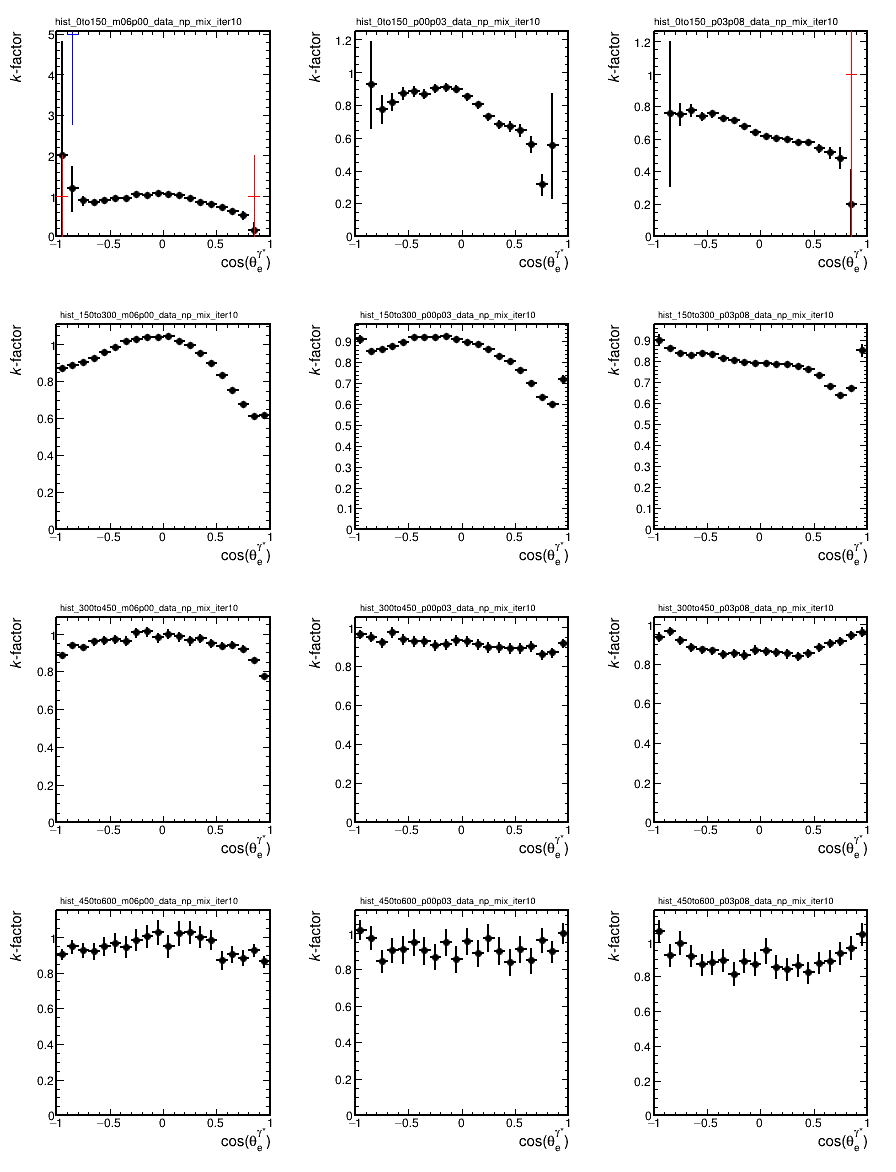

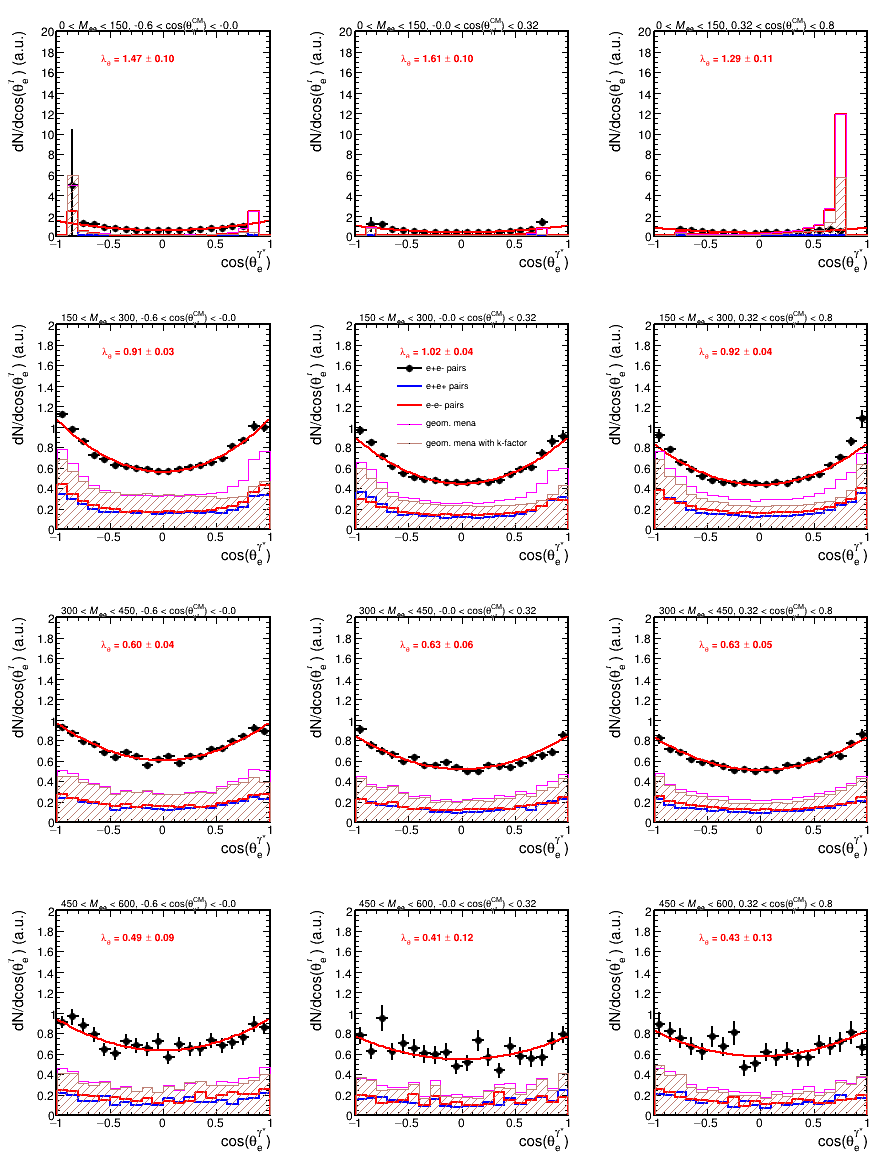

In [18]:
if not analyse_3d:
    cck.Draw()
    cck.SaveAs(f"{DIR_NAME}/kfactor.gif")
    
    csig.Draw()
    csig.SaveAs(f"{DIR_NAME}/signal.gif")
    csig.SaveAs(f"{DIR_NAME}/signal.eps")


Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_mass_z_np.gif has been created


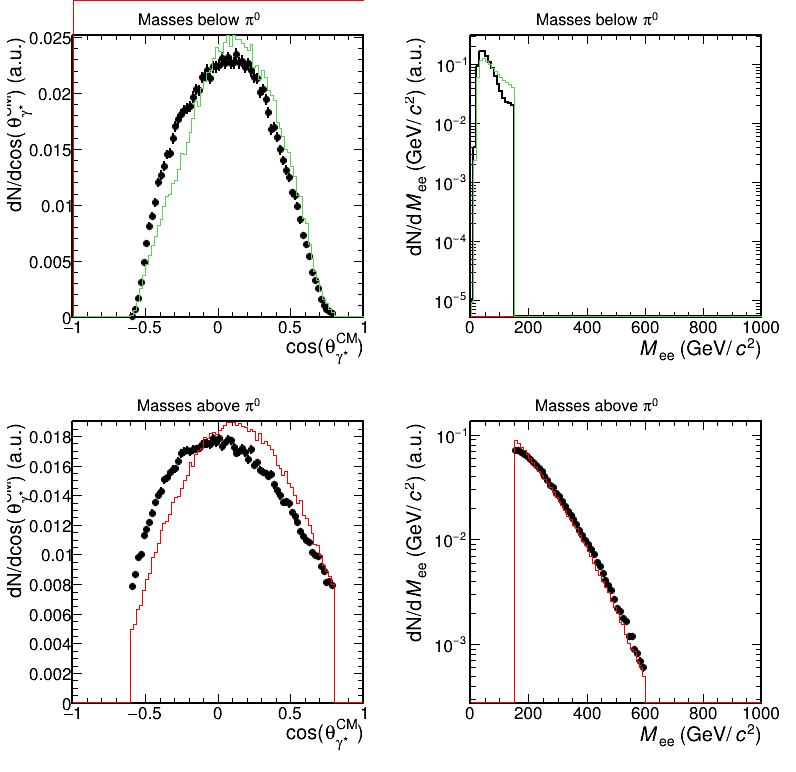

In [19]:
can_mass_z_np = show_mass_z(histsData_np, histMakerMC_pi0, histMakerMC_rho_heli0_np, histMakerMC_mix, event_mixing, fraction, DIR_NAME, "np")

Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_mass_z_pp.gif has been created


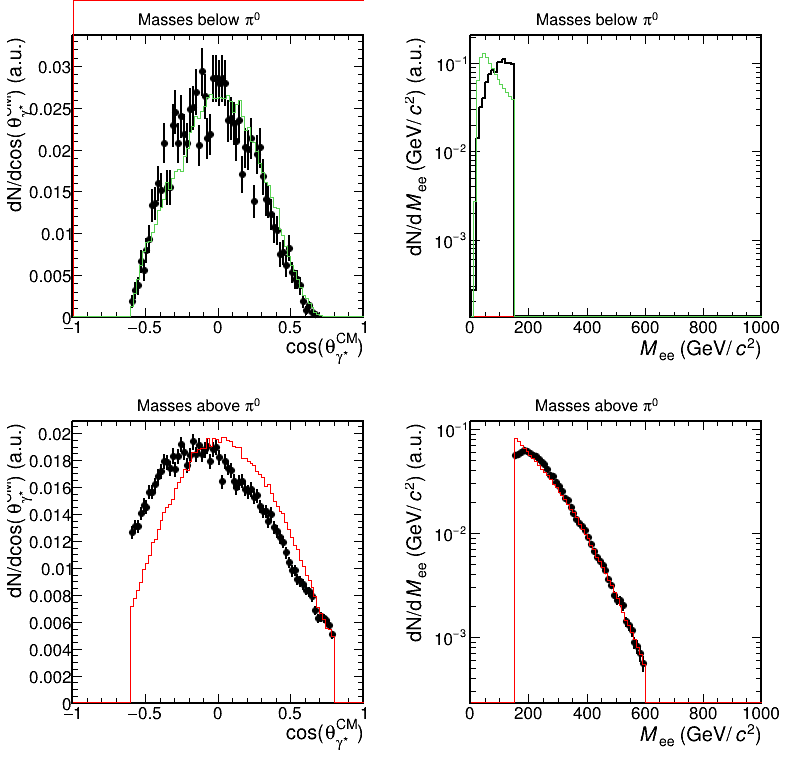

In [20]:
can_mass_z_pp = show_mass_z(histsData_pp, histMakerMC_pi0, histMakerMC_rho_heli0_pp, histMakerMC_mix, event_mixing, fraction, DIR_NAME, "pp")

Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_mass_z_nn.gif has been created


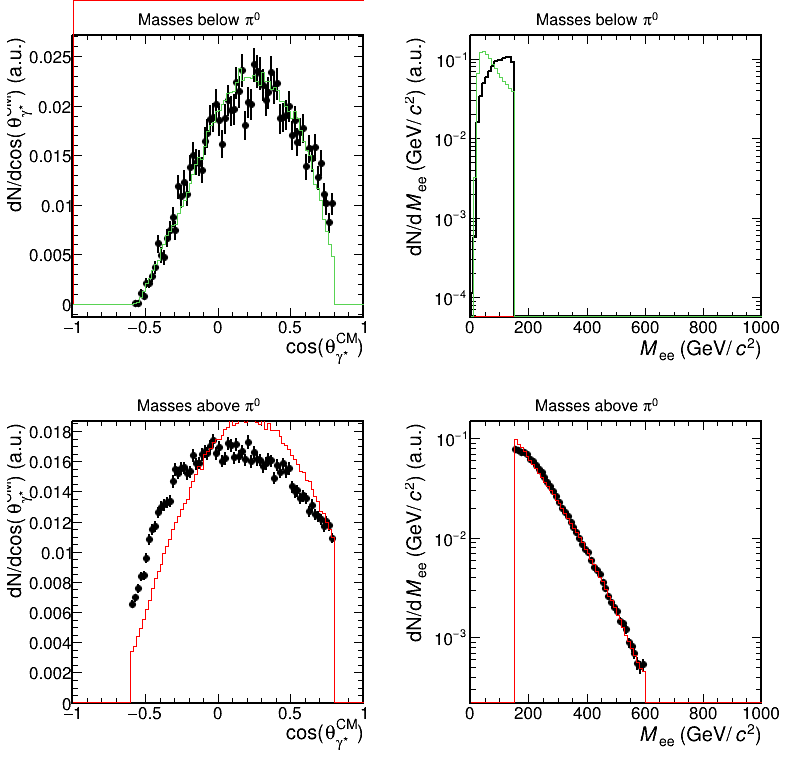

In [21]:
can_mass_z_np = show_mass_z(histsData_nn, histMakerMC_pi0, histMakerMC_rho_heli0_nn, histMakerMC_mix, event_mixing, fraction, DIR_NAME, "nn")

Info in <TCanvas::Print>: gif file results_ag1580ag_1d_symm_HX/can_mass_z_sig.gif has been created


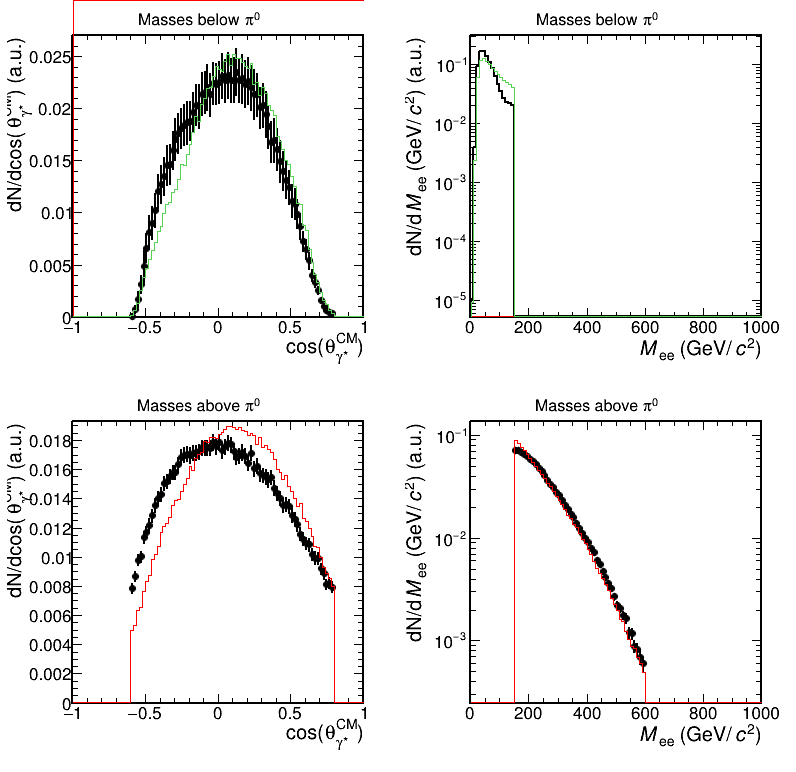

In [22]:
can_mass_z_sig = show_mass_z(histsData_sig, histMakerMC_pi0, histMakerMC_rho_heli0_np, histMakerMC_mix, event_mixing, fraction, DIR_NAME, "sig")

ASImage2gif():1010:<results_ag1580ag_1d_symm_HX/cacc.gif> 
GIF-LIB undefined error 0.
Error in <TASImage::WriteImage>: error writing file results_ag1580ag_1d_symm_HX/cacc.gif


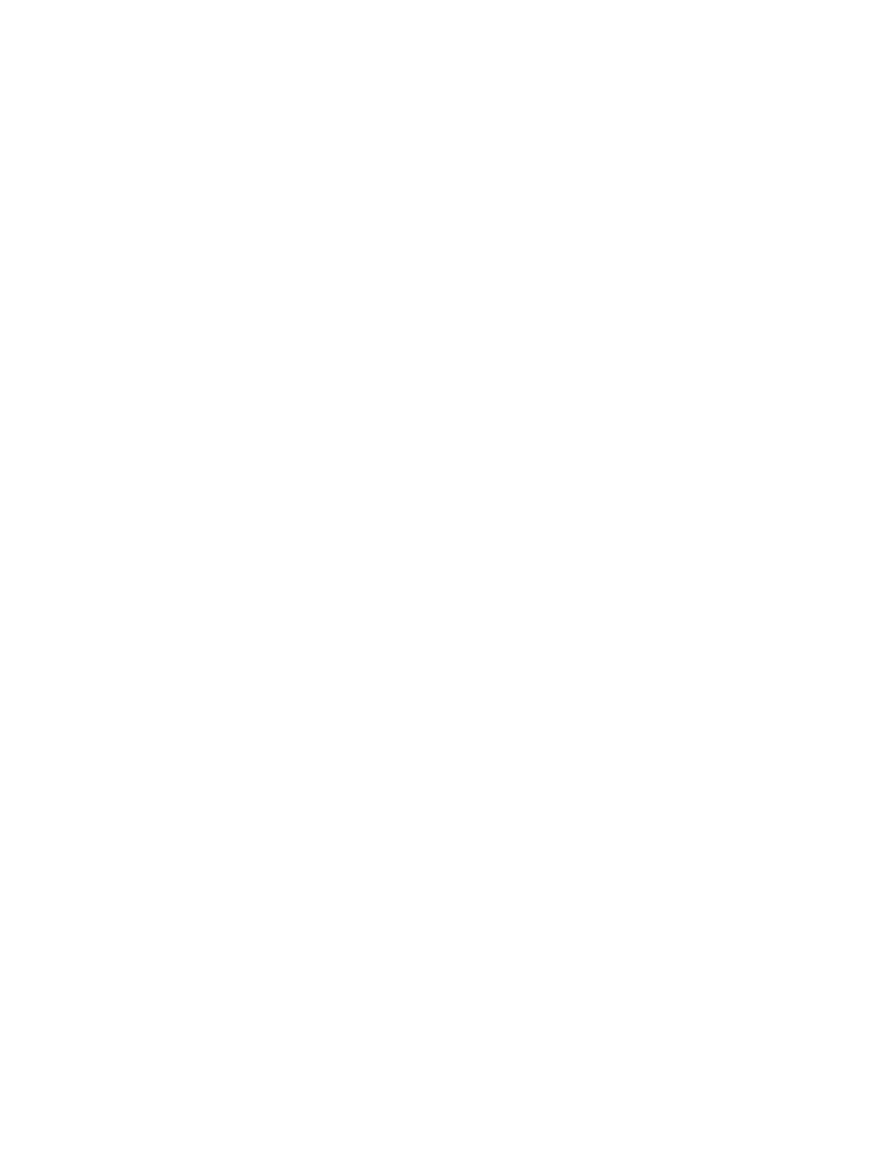

In [23]:
if not analyse_3d:
    cacc.Draw()
    cacc.SaveAs(f"{DIR_NAME}/cacc.gif")

In [24]:
import math
import pandas as pd

a_np = df_np['yield']/(math.pi * (df_np['lambda_theta'] + 3)) * (3./4)
a_pp = df_pp['yield']/(math.pi * (df_pp['lambda_theta'] + 3)) * (3./4)
a_nn = df_nn['yield']/(math.pi * (df_nn['lambda_theta'] + 3)) * (3./4)

yield_sig = df_np['yield'] - df_pp['yield'] - df_nn['yield'] 

term_np = (4./15) * a_np * math.pi * (5 + 3*df_np['lambda_theta'])
term_pp = (4./15) * a_pp * math.pi * (5 + 3*df_pp['lambda_theta'])
term_nn = (4./15) * a_nn * math.pi * (5 + 3*df_nn['lambda_theta'])

term_x = term_np - 1.0*(term_pp + term_nn)
lambda_theta_sig = (3 * term_x - 5 * yield_sig) / (3 * yield_sig - term_x)

a_sig = yield_sig/(math.pi * (lambda_theta_sig + 3)) * (3./4)

lambda_phi_sig = (a_np * df_np['lambda_phi'] - a_pp * df_pp['lambda_phi'] - a_nn * df_nn['lambda_phi']) / a_sig
lambda_theta_phi_sig = (a_np * df_np['lambda_theta_phi'] - a_pp * df_pp['lambda_theta_phi'] - a_nn * df_nn['lambda_theta_phi']) / a_sig

df_result = pd.DataFrame(columns=['a_np', 'a_pp', 'a_nn', 'yield_sig', 'term_np', 'term_pp', 'term_nn', 'term_x', 'a_sig', 'lambda_theta_sig', 'lambda_phi_sig', 'lambda_theta_phi_sig'])
df_result['a_np'] = a_np
df_result['a_pp'] = a_pp
df_result['a_nn'] = a_nn
df_result['term_np'] = term_np
df_result['term_pp'] = term_pp
df_result['term_nn'] = term_nn
df_result['term_x'] = term_x
df_result['yield_sig'] = yield_sig
df_result['a_sig'] = a_sig
df_result['lambda_theta_sig'] = lambda_theta_sig
df_result['lambda_phi_sig'] = lambda_phi_sig
df_result['lambda_theta_phi_sig'] = lambda_theta_phi_sig

df_result

KeyError: 'lambda_phi'